# Meta-analysis

Load in processed data and explore model fits via meta-analysis

In [1]:
### autoreload
%reload_ext autoreload
%autoreload 2

# custom
from calcification.analysis import analysis, analysis_utils, meta_regression
from calcification.utils import config
from calcification.plotting import analysis as analysis_plot
from calcification.plotting import plot_utils, climatology, plot_config
from calcification.processing import (
    climatology as climatology_processing,
    process,
)

# custom plotting
import matplotlib.pyplot as plt

In [2]:
# load extracted data (with effect sizes)
data_df = process.process_extracted_calcification_data(
    fp=config.data_dir / "Orlando_data.xlsx",
)

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing/cleaning.py:86: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(" ", np.nan)
INFO:calcification.processing.locations:Using cached locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
INFO:calcification.processing.taxonomy:Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml
INFO:calcification.processing.carbonate_processing:Loading measured values...


Calculating carbonate chemistry:   0%|          | 0/3393 [00:00<?, ?it/s]

Assigning treatment groups:   0%|          | 0/317 [00:00<?, ?it/s]

INFO:root:Aggregating treatments with individual samples...


  0%|          | 0/149 [00:00<?, ?it/s]

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/analysis/analysis.py:337: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(0, mean_value).infer_objects(copy=False)


In [78]:
local_climatology_df, global_future_anomaly_df, global_anomaly_df = (
    process.process_climatology_data(
        data_df,
        config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
        config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
        config.resources_dir / "locations.yaml",
    )
)


INFO:root:Loading climatology data...
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
INFO:root:Unique locations in climatology: 198, locations in working

Generating batched anomalies for ph:   0%|          | 0/76 [00:00<?, ?it/s]

Generating batched anomalies for sst:   0%|          | 0/76 [00:00<?, ?it/s]

### Initial model exploration

An intercept is included in models which only include abiotic treatments (i.e. changes in pH/temperature). In this case, the following can be interpreted:
- Intercept – represents the estimated calcification reponse when all moderators are zero (i.e. control condition). This relates to the baseline calcification rate before experimental manipulation, averaged across all the organism types.
- Coefficients – the coefficients represent the estimated change in calcification for a one-unit change in pH or temperature (note difference in signs, since for experimental treatments $\Delta$ pH < 0 while $\Delta$ T > 0) while holding the other coefficient constant.

Including an intercept allows the regression to find its baseline/natural position rather than forcing it through the origin. This would force the assumption that zero change in pH and temperature must result in zero change in calcification (which may not be true, especially given experimental/methodological uncertainty).

The following code blocks illustrate the effect on the significance of the moderators in both the presence and absence of a model intercept.

In [79]:
# declare effect type for subsequent investigation
effect_type = "st_relative_calcification"

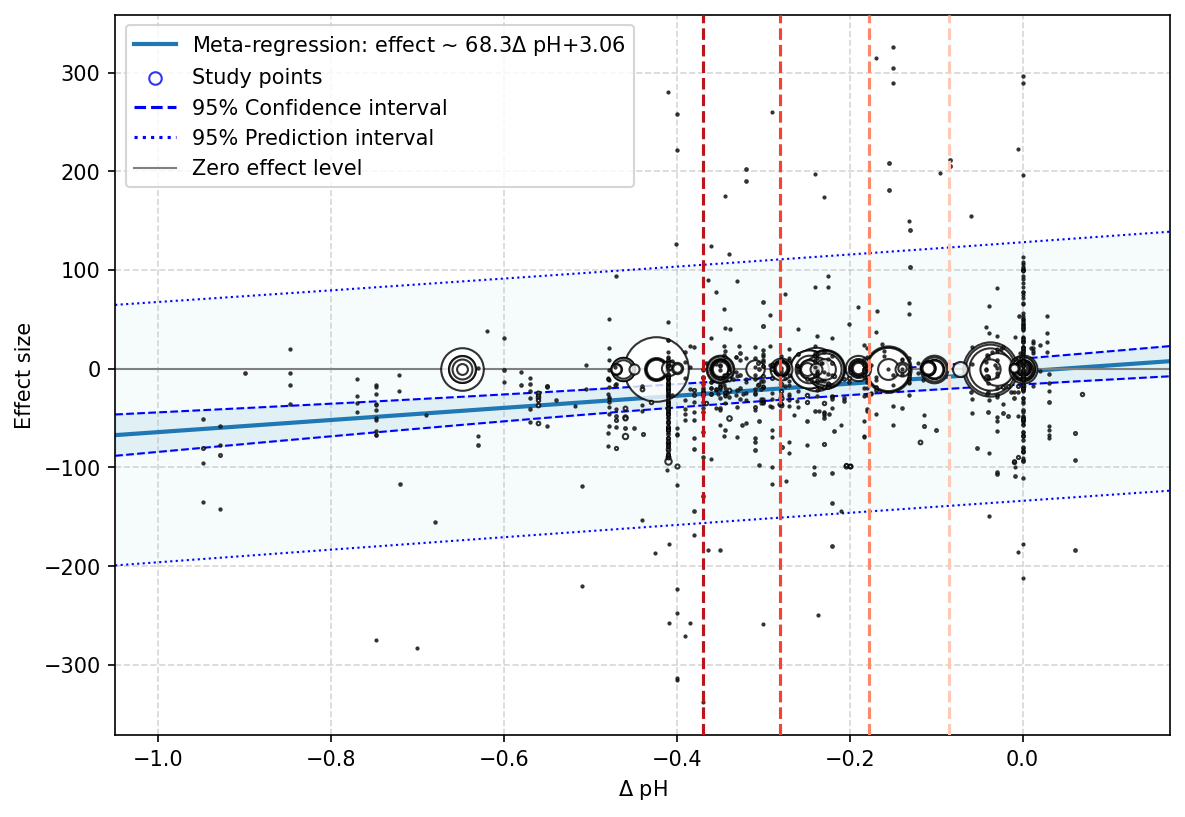

In [81]:
metafor_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()
print(metafor_model.summary)

fig, ax = analysis_plot.MetaRegressionPlotter(
    model=metafor_model.model,
    x_axis_moderator="delta_ph",
    future_global_anomaly_df=global_future_anomaly_df,
).plot()

In [ ]:
### ILLUSTRATING INTERCEPT (CARBONATE CHEMISTRY ONLY)
metafor_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()
metafor_model.get_model_summary()

metafor_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t - 1",
).fit_model()
metafor_model.get_model_summary()

In [ ]:
### ILLUSTRATING INTERCEPT (WITH CORE GROUPINGS)
metafor_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t + factor(core_grouping)",
).fit_model()
metafor_model.get_model_summary()

metafor_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t + factor(core_grouping) - 1",
).fit_model()
metafor_model.get_model_summary()


##### Interpretation: shifts in intercept value as more moderators are added
 
In the case of including taxonomical information (via `core_groupings` factor), an intercept is unnecessary. In this case an intercept would result in a random value of `core_groupings` being assigned as baseline and all other factor values compared against it. While this is useful to investigate comparisons between organisms and a particular reference taxon, it is not the current goal. Removing the intercept means that each `core_grouping` is assigned its own coefficient representing its baseline effect (the expected value of calcification rate for this grouping when the other moderators are zero).   

The addition of the `core_grouping` variable improves the model (test of moderators statistic increases, residual heterogeneity decreases, AICc decreases), suggesting that taxonomic group is an important moderator.

The coefficients for delta_ph and delta_t remain remarkably stable between models, suggesting their effects are robust regardless of which organisms are being considered.

The large discrepency between the magnitudes of the coefficients is perhaps surprising, although it should be noted that due to the logarithmic nature of the pH scale a change by 1 unit represents a 10 times increase in acidity. This puts the temperature slope in perspective. Additionally, a number of studies suggest a non-linear trend in calcification rate with increasing temperature. The suggested quadratic would result in a linear slope under-representing the likely ultimately-negative impact of increasing temperature with respect to the control. Finally, multiple studies reported sample mortality at more extreme treatment conditions, and the resulting survivorship effect may represent resistant species with only smaller sample sizes at the higher temperatures: especially since such mortalities are rarely reported consistently.

In [ ]:
### INIITAL NAIVE (ILLUSTRATION)
metafor_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ 1",
).fit_model()
metafor_model.get_model_summary()

##### Interpretation

As above, the model intercept represents the estimated overall mean effect of the treatments (changing pH and temperature) on calcification rates across all studies and organisms in the meta-analysis, after accounting for the nested random effects structure relating to the nested structure of the dataset (multiple treatments within studies).

A negative intercept indicates that, on average across all studies and organisms, the calcification rates decreased in response to the experimental treatments. A high statistical significance (e.g. p < 0.0001) indicates that this decrease is unlikely due to chance. The confidence interval (95%) shows the range in which the true mean effect is likely to fall.

However, the substantial between-study variance (sigma^2.1 = 1775.21) suggests that the response varies considerably across different organisms and/or experimental conditions.

In [ ]:
### INIITAL CORE GROUPINGS (ILLUSTRATION)
metafor_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ factor(core_grouping) - 1",
).fit_model()
metafor_model.get_model_summary()

In [ ]:
### A MORE REASONABLE MODEL (DELTA PH AND DELTA T, ADDITIVE)
metafor_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph + delta_t",
).fit_model()
metafor_model.get_model_summary()


analysis_plot.plot_multiple_metaregression_axes(
    model=metafor_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph + delta_t



Removed 14 outlier(s) (from 860 samples) based on Cook's distance threshold of 0.12

----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  1101
Total samples of relevant investigation:  860
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 14
Final sample count: 846 (241 rows dropped)


INFO:calcification.analysis.meta_regression:Model fitting complete.





Multivariate Meta-Analysis Model (k = 846; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
-4238.8602   8477.7204   8487.7204   8511.4052   8487.7920   

Variance Components:

               estim     sqrt  nlvls  fixed           factor 
sigma^2.1  1054.8209  32.4780    110     no     original_doi 
sigma^2.2   630.3492  25.1068    846     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 843) = 57751.2616, p-val < .0001

Test of Moderators (coefficients 2:3):
QM(df = 2) = 49.0182, p-val < .0001

Model Results:

          estimate      se     zval    pval     ci.lb    ci.ub      
intrcpt    -3.6606  4.2943  -0.8524  0.3940  -12.0772   4.7561      
delta_ph   48.1369  7.5084   6.4110  <.0001   33.4207  62.8532  *** 
delta_t    -3.7995  0.9166  -4.1453  <.0001   -5.5960  -2.0030  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




(<Figure size 1800x900 with 2 Axes>,
 array([<Axes: xlabel='$\\Delta$ pH', ylabel='Effect size'>,
        <Axes: xlabel='$\\Delta$ T', ylabel='Effect size'>], dtype=object))

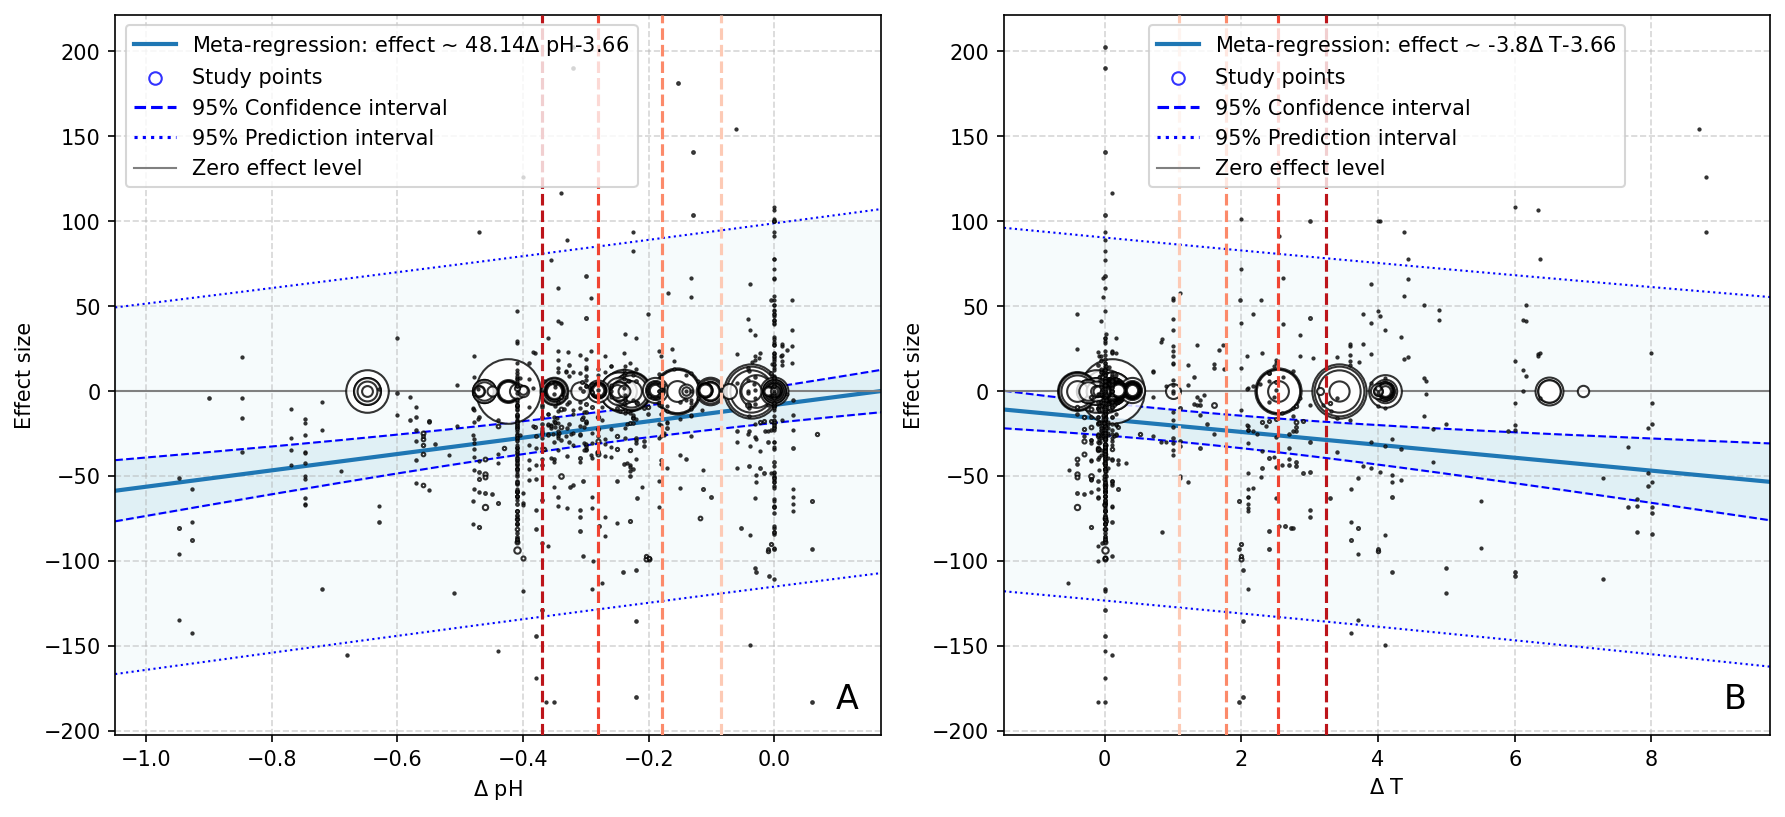

In [28]:
### FILTERING FOR OUTLIERS
filtered_effects_df = data_df.copy()

filtered_effects_df = filtered_effects_df[
    analysis_utils.filter_robust_zscore(
        filtered_effects_df["st_relative_calcification"]
    )
    & analysis_utils.filter_robust_zscore(
        filtered_effects_df["st_relative_calcification_var"]
    )
]

additive_model = meta_regression.MetaforModel(
    filtered_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph + delta_t",
).fit_model()
additive_model.get_model_summary()

analysis_plot.plot_multiple_metaregression_axes(
    model=additive_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='delta_ph', ylabel='delta_t'>)

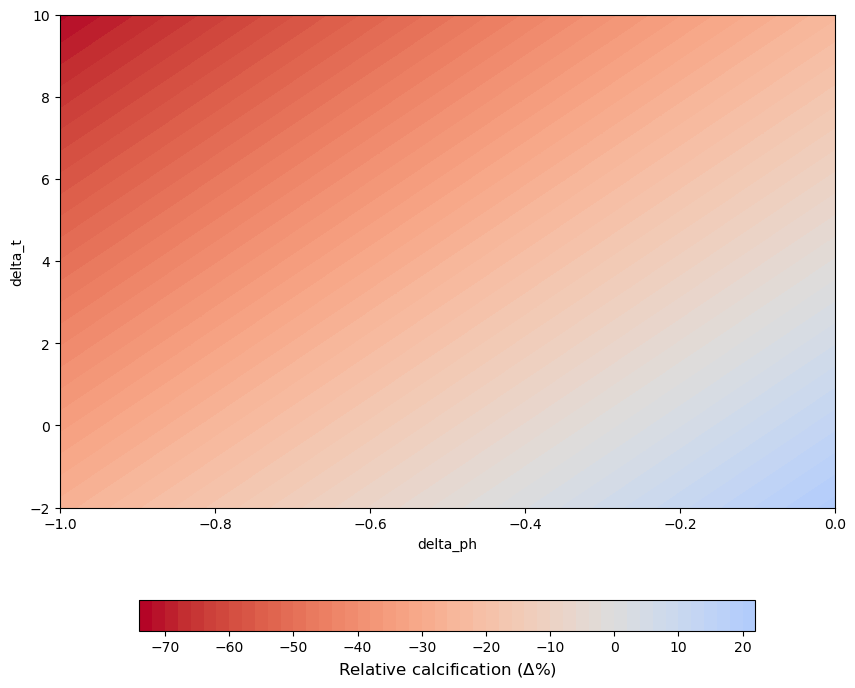

In [29]:
analysis_plot.plot_model_surface_2d(
    additive_model.model,
    ["delta_ph", "delta_t"],
    prediction_limits={"delta_ph": (-1, 0), "delta_t": (-2, 10)},
)

##### Interpretation
Group Effects (Absolute Estimates)
Each coefficient now represents the actual mean calcification response for that organism group:

CCA (Crustose Coralline Algae): -35.72 (p < 0.0001)
Shows a strong negative calcification response to pH and temperature treatments
Coral: -10.56 (p = 0.0316)
Shows a moderate negative calcification response
Foraminifera: +22.08 (p = 0.3524)
Shows a positive mean response, but it's not statistically significant (wide confidence interval crossing zero)
Halimeda: -43.90 (p = 0.0004)
Shows a strong negative calcification response
Other algae: -48.51 (p < 0.0001)
Shows the strongest negative calcification response among all groups

Direct Group Comparisons
Now you can directly compare the magnitude of effects across groups:

Most resistant to calcification decline: Foraminifera (+22.08, though not significant)
Moderate decline: Coral (-10.56)
Stronger decline: CCA (-35.72)
Severe decline: Halimeda (-43.90) and Other algae (-48.51)

The significant negative values for most groups indicate that pH and temperature treatments generally reduce calcification rates, but the magnitude varies substantially across taxonomic groups. Notably, Foraminifera appear potentially resilient (showing a non-significant positive trend), while algae groups (especially "Other algae" and Halimeda) appear most vulnerable with the largest negative responses.

In [ ]:
### A MORE REASONABLE MODEL, MORE COMPLEX MODEL (DELTA PH AND DELTA T, INTERACTIVE)
interaction_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()
interaction_model.get_model_summary()

analysis_plot.plot_multiple_metaregression_axes(
    model=interaction_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

In [ ]:
analysis_plot.plot_model_surface_2d(
    interaction_model.model,
    ["delta_ph", "delta_t"],
    prediction_limits={"delta_ph": (-1, 0), "delta_t": (-2, 10)},
)

In [ ]:
### NOW CAPTURING DIFFERENCES BETWEEN CORE GROUPINGS

interaction_cg_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t + factor(core_grouping) - 1",
).fit_model()
interaction_cg_model.get_model_summary()

analysis_plot.plot_multiple_metaregression_axes(
    model=interaction_cg_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

### Investigating absolute values

In [ ]:
### SIMPLEST ABSOLUTE VALUES
phtot_abs_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "phtot_temp_mv"],
    formula=f"{effect_type} ~ phtot",
    required_columns=["phtot", "temp"],
).fit_model()
phtot_abs_model.get_model_summary()

temp_abs_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ temp",
    required_columns=["temp", "phtot"],
).fit_model()
temp_abs_model.get_model_summary()

phtot_plus_temp_abs_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ phtot + temp",
    required_columns=["phtot", "temp"],
).fit_model()
phtot_plus_temp_abs_model.get_model_summary()

phtot_cross_temp_abs_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ phtot * temp",
    required_columns=["phtot", "temp"],
).fit_model()
phtot_cross_temp_abs_model.get_model_summary()

phtot_cross_temp_abs_cgs_model = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ phtot * temp + factor(core_grouping)",
    required_columns=["phtot", "temp"],
).fit_model()
phtot_cross_temp_abs_cgs_model.get_model_summary()

### Comparing between units

TODO: commentary

In [ ]:
### AREA-NORMALISED VS MASS-NORMALISED


mass_norm_model = meta_regression.MetaforModel(
    data_df[data_df["st_calcification_unit"] == "mgCaCO3 g-1d-1"],
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t + factor(core_grouping)",
).fit_model()

area_norm_model = meta_regression.MetaforModel(
    data_df[data_df["st_calcification_unit"] == "mgCaCO3 cm-2d-1"],
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t + factor(core_grouping)",
).fit_model()


analysis_plot.plot_multiple_metaregression_axes(
    # ax=axes[0, :],
    model=mass_norm_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

analysis_plot.plot_multiple_metaregression_axes(
    # ax=axes[1, :],
    model=area_norm_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

### Testing for publication bias

In [ ]:
### FUNNEL PLOTTING FOR PUBLICATION BIAS

# TODO
analysis_plot.plot_funnel_from_model(
    interaction_cg_model.model,
    main="Funnel plot of effect sizes",
    effect_type="Effect Size",
    shade_colors=["#d6d6d6", "#b8b8b8", "#8a8a8a"],
    back_color="white",
    level=[0.1, 0.05, 0.01],
    legend=True,
    hlines=[0],
    yaxis="seinv",
    digits=[1, 3],
    las=1,
    xaxs="i",
    yaxs="i",
    xlim=[
        -max(
            abs(interaction_cg_model.df[effect_type].min()),
            abs(interaction_cg_model.df[effect_type].max()),
        ),
        max(
            abs(interaction_cg_model.df[effect_type].min()),
            abs(interaction_cg_model.df[effect_type].max()),
        ),
    ],
    ylim=[0, 4],
    plot_in_python=True,
    figsize=(10, 8),
    save_path=config.fig_dir / "benthic_organsism_funnel_plot.png",
)

##### Interpretation

TODO

## More formally: using MuMIn

In [ ]:
# ### scan potential interactive models via MuMIn dredge
# temp_formula, temp_df = analysis.preprocess_df_for_meta_model(data_df, treatment = ['phtot', 'temp', 'phtot_temp_mv'])
# analysis.run_parallel_dredge(temp_df, global_formula=f"{effect_type} ~ delta_ph + delta_t", n_cores=16)

In [ ]:
# ### scan potential interactive models via MuMIn dredge
# temp_formula, temp_df = analysis.preprocess_df_for_meta_model(data_df, treatment = ['phtot', 'temp', 'phtot_temp_mv'])
# analysis.run_parallel_dredge(temp_df, global_formula=f"{effect_type} ~ delta_ph * delta_t", n_cores=16)

In [ ]:
# ### scan potential interactive models via MuMIn dredge (absolute values)
# temp_formula, temp_df = analysis.preprocess_df_for_meta_model(data_df, treatment=['temp', 'phtot', 'phtot_temp_mv'])
# analysis.run_parallel_dredge(temp_df, global_formula=f"{effect_type} ~ phtot + temp", n_cores=16)

In [ ]:
# ### scan potential interactive models via MuMIn dredge (absolute values)
# temp_formula, temp_df = analysis.preprocess_df_for_meta_model(data_df, treatment=['temp', 'phtot', 'phtot_temp_mv'])
# analysis.run_parallel_dredge(temp_df, global_formula=f"{effect_type} ~ phtot * temp", n_cores=16)

In [ ]:
%reload_ext autoreload
%autoreload 2

In [18]:
dredgeConfig = meta_regression.DredgeConfig(
    effect_type=effect_type,
    global_formula=f"{effect_type} ~ phtot * temp + factor(core_grouping)",
    treatment=["temp", "phtot", "phtot_temp_mv"],
)

meta_regression.DredgeAnalysis(data_df, dredgeConfig).run_parallel()

INFO:calcification.analysis.meta_regression:Running parallel dredge analysis with formula: st_relative_calcification ~ phtot * temp + factor(core_grouping)
INFO:calcification.analysis.meta_regression:Using 16 cores for parallel processing



Removed 13 outlier(s) (from 942 samples) based on Cook's distance threshold of 0.11

----- PROCESSING SUMMARY -----
Treatment:  ['temp', 'phtot', 'phtot_temp_mv']
Total samples in input data:  1239
Total samples of relevant investigation:  942
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 13
Final sample count: 929 (297 rows dropped)


/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "duration". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "loc". Fall back to string conversion. The error is: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
  warnings.warn('Error while trying to convert '
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "notes++". Fall back to string conversion. The

,(Intercept),factor(core_grouping),phtot,temp,phtot:temp,df,logLik,AICc,delta,weight
15,1,1.0,NaN,NaN,NaN,10,-4155.622355,8331.522487,0.000000,9.939029e-01
7,1,1.0,NaN,NaN,NaN,9,-4161.742088,8341.711163,10.188676,6.093981e-03
3,1,1.0,NaN,NaN,NaN,8,-4170.340418,8356.862195,25.339708,3.125332e-06
14,1,NaN,NaN,NaN,NaN,6,-4188.343035,8388.791598,57.269111,3.643464e-13
6,1,NaN,NaN,NaN,NaN,5,-4194.344827,8398.764937,67.242450,2.487892e-15
2,1,NaN,NaN,NaN,NaN,4,-4203.199223,8414.448572,82.926085,9.776273e-19
5,1,1.0,NaN,NaN,NaN,8,-4867.081910,9750.320342,1418.797855,8.115294e-309
1,1,1.0,NaN,NaN,NaN,7,-4877.982336,9770.086280,1438.563793,4.141765e-313
4,1,NaN,NaN,NaN,NaN,4,-4900.001889,9808.047068,1476.524581,2.366574e-321
0,1,NaN,NaN,NaN,NaN,3,-4910.728604,9827.483154,1495.960667,0.000000e+00


In [25]:
dredgeConfig = meta_regression.DredgeConfig(
    effect_type=effect_type,
    global_formula=f"{effect_type} ~ delta_ph * delta_t + factor(core_grouping)",
    treatment=["temp", "phtot", "phtot_temp_mv"],
)

meta_regression.DredgeAnalysis(data_df, dredgeConfig).run_parallel()

INFO:calcification.analysis.meta_regression:Running parallel dredge analysis with formula: st_relative_calcification ~ delta_ph * delta_t + factor(core_grouping)
INFO:calcification.analysis.meta_regression:Using 16 cores for parallel processing
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "duration". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "loc". Fall back to string conversion. The error is: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()



Removed 13 outlier(s) (from 942 samples) based on Cook's distance threshold of 0.11

----- PROCESSING SUMMARY -----
Treatment:  ['temp', 'phtot', 'phtot_temp_mv']
Total samples in input data:  1239
Total samples of relevant investigation:  942
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 13
Final sample count: 929 (297 rows dropped)






INFO:calcification.analysis.meta_regression:Parallel dredge analysis completed successfully. Found 10 model combinations.


,(Intercept),delta_ph,delta_t,factor(core_grouping),delta_ph:delta_t,df,logLik,AICc,delta,weight
16,1,68.394361,-4.963222,1.0,-6.160131,10,-4836.869888,9693.979427,0.000000,9.918453e-01
8,1,57.915821,-3.961409,1.0,NaN,9,-4842.692767,9703.581399,9.601972,8.154591e-03
6,1,51.268117,NaN,1.0,NaN,8,-4854.751635,9725.659791,31.680364,1.309605e-07
12,1,69.466379,-4.709120,NaN,-6.071015,6,-4869.950442,9751.991991,58.012564,2.507124e-13
7,1,NaN,-2.461516,1.0,NaN,8,-4870.177278,9756.511078,62.531651,2.617390e-14
4,1,59.173493,-3.728880,NaN,NaN,5,-4875.733580,9761.532166,67.552739,2.125950e-15
5,1,NaN,NaN,1.0,NaN,7,-4877.982336,9770.086280,76.106853,2.951555e-17
2,1,52.889046,NaN,NaN,NaN,4,-4886.828855,9781.701001,87.721574,8.870461e-20
3,1,NaN,-2.194485,NaN,NaN,4,-4903.523525,9815.090340,121.110913,4.983602e-27
1,1,NaN,NaN,NaN,NaN,3,-4910.728604,9827.483154,133.503727,1.015028e-29


In [26]:
### scan potential interactive models via MuMIn dredge (absolute values and core groupings)
dredgeConfig = meta_regression.DredgeConfig(
    effect_type=effect_type,
    global_formula=f"{effect_type} ~ phtot * temp + delta_t * delta_ph + factor(core_grouping)",
    treatment=["temp", "phtot", "phtot_temp_mv"],
)

meta_regression.DredgeAnalysis(data_df, dredgeConfig).run_parallel()

INFO:calcification.analysis.meta_regression:Running parallel dredge analysis with formula: st_relative_calcification ~ phtot * temp + delta_t * delta_ph + factor(core_grouping)
INFO:calcification.analysis.meta_regression:Using 16 cores for parallel processing
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "duration". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "loc". Fall back to string conversion. The error is: The truth value of an array with more than one element is ambiguous. Use a.an


Removed 12 outlier(s) (from 942 samples) based on Cook's distance threshold of 0.13

----- PROCESSING SUMMARY -----
Treatment:  ['temp', 'phtot', 'phtot_temp_mv']
Total samples in input data:  1239
Total samples of relevant investigation:  942
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 12
Final sample count: 930 (297 rows dropped)







INFO:calcification.analysis.meta_regression:Parallel dredge analysis completed successfully. Found 50 model combinations.


,(Intercept),delta_ph,delta_t,factor(core_grouping),phtot,temp,delta_ph:delta_t,phtot:temp,df,logLik,AICc,delta,weight
128,1,230.354440,2.110721,1.0,171.134403,89.344178,2.746531,-12.157636,13,-4129.734186,8285.929132,0.000000,9.737813e-01
96,1,232.831397,1.357325,1.0,122.873826,75.658738,NaN,-10.396512,12,-4134.502285,8293.399008,7.469876,2.324869e-02
64,1,230.866626,-0.757192,1.0,-162.746976,-4.968990,-6.801332,NaN,12,-4136.663148,8297.720733,11.791601,2.678846e-03
94,1,230.580117,NaN,1.0,121.927242,75.870803,NaN,-10.277842,11,-4140.023902,8302.381137,16.452005,2.605877e-04
32,1,219.241998,0.928905,1.0,-163.682103,-4.852757,NaN,NaN,11,-4142.345881,8307.025095,21.095963,2.555825e-05
48,1,221.926468,-5.474376,1.0,-154.940836,NaN,-6.556008,NaN,11,-4144.053495,8310.440322,24.511191,4.633659e-06
30,1,217.623445,NaN,1.0,-161.903021,-4.075952,NaN,NaN,10,-4147.808196,8315.893820,29.964688,3.031881e-07
16,1,210.833309,-3.740118,1.0,-155.944503,NaN,NaN,NaN,10,-4149.665156,8319.607739,33.678607,4.734181e-08
14,1,201.480559,NaN,1.0,-151.915742,NaN,NaN,NaN,9,-4158.646122,8335.518945,49.589813,1.660238e-11
95,1,NaN,-0.353932,1.0,245.924881,50.563493,NaN,-6.873789,11,-4157.636698,8337.606730,51.677598,5.845392e-12


#### MuMIn interpretation

- Index – model number (simply position in the queue of permutations).
- df (degrees of freedom) – number of moderators in the model (i.e., the number of predictors or independent variables included).
- logLik (log likelihood) – measure of model fit; higher values indicate a better fit to the data. A very negative log likelihood isn't inherently a problem; it often occurs when the scale of the data or the number of observations is large. What matters is the relative comparison of log likelihoods between models, as it is used to compute metrics like such as AIC (Akaike Information Criterion)
- AICc (corrected AIC) – measure of model fit which rewards good fit and penalises model complexity (number of parameters): lower is better.
- delta – difference between the AICc of the current model and the AICc of the best-performing model (delta = 0 for the best model).
- weight – the relative likelihood of the model compared to all other models in the set, normalized to sum to 1 (useful for model averaging).
- Additional Notes:
    - logLik is particularly useful for comparing nested models.
    - AICc is preferred over AIC for small sample sizes, as it includes a correction for finite sample sizes.
    - delta values:
        - models with delta < 2 are considered to have substantial support.
        - models with delta between 4 and 7 have considerably less support.
        - models with delta > 10 are unlikely to be good candidates.
    - weight can be interpreted as the probability that a given model is the best model in the set.

##### Interpretation of model statistics:


'Test of Moderators'
- quantification of the extent to which a set of moderators collectively explain a significant amount of variation in the outcome variable.


## Extending to predictions

In [ ]:
### IDEAL
# temp_out = pd.DataFrame(
#     analysis.generate_location_specific_predictions(
#         model=interaction_cg_model,
#         df=local_climatology_df,
#         scenario_var="sst",
#         moderator_pos=2,
#     )
# )

# temp_out[temp_out["percentile"] == "mean"].predicted_effect_size

In [ ]:
# sst_all = pd.DataFrame(
#     analysis.generate_location_specific_predictions(
#         model=interaction_cg_model, df=local_climatology_df, scenario_var="sst"
#     )
# )
# sst_preds = (
#     sst_all.groupby(["scenario", "time_frame", "percentile"])[
#         ["anomaly_value", "predicted_effect_size"]
#     ]
#     .mean()
#     .reset_index()
# )
# sst_preds_shortform = sst_preds.pivot(
#     index=["scenario", "time_frame"],
#     columns="percentile",
#     values=["anomaly_value", "predicted_effect_size"],
# )
# sst_preds_shortform.columns = [
#     "_".join(col).strip() for col in sst_preds_shortform.columns.values
# ]
# sst_preds_shortform.reset_index(inplace=True)
# # sst_preds_shortform.set_index(['scenario', 'time_frame'], inplace=True)

# ph_all = pd.DataFrame(
#     analysis.generate_location_specific_predictions(
#         model=interaction_cg_model, df=local_climatology_df, scenario_var="ph"
#     )
# )
# ph_preds = (
#     ph_all.groupby(["scenario", "time_frame", "percentile"])[
#         ["anomaly_value", "predicted_effect_size"]
#     ]
#     .mean()
#     .reset_index()
# )
# ph_preds_shortform = ph_preds.pivot(
#     index=["scenario", "time_frame"],
#     columns="percentile",
#     values=["anomaly_value", "predicted_effect_size"],
# )
# ph_preds_shortform.columns = [
#     "_".join(col).strip() for col in ph_preds_shortform.columns.values
# ]
# ph_preds_shortform.reset_index(inplace=True)
# # ph_preds_shortform.set_index(['scenario', 'time_frame'], inplace=True)
# ph_preds_shortform["scenario_var"] = "ph"
# sst_preds_shortform["scenario_var"] = "sst"

# predictions_shortform = pd.concat([sst_preds_shortform, ph_preds_shortform], axis=0)
# spatial_predictions = pd.concat([sst_all, ph_all], axis=0)

In [ ]:
### TODO: visualise prediction of each model component. Requires more flexible function which takes each model component and plots it
# _,_ = plotting.plot_global_timeseries(predictions_shortform, plot_vars=['sst', 'ph'], figsize=(10, 10), dpi=300)

## Investigating groupings

In [8]:
### create a dataframe for each grouping
coral_effects_df = data_df[data_df.core_grouping == "Coral"]
cca_effects_df = data_df[data_df.core_grouping == "CCA"]
foraminifera_effects_df = data_df[data_df.core_grouping == "Foraminifera"]
other_algae_effects_df = data_df[data_df.core_grouping == "Other algae"]
halimeda_effects_df = data_df[data_df.core_grouping == "Halimeda"]

INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t



Removed 13 outlier(s) (from 683 samples) based on Cook's distance threshold of 0.11

----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  868
Total samples of relevant investigation:  683
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 13
Final sample count: 670 (185 rows dropped)


INFO:calcification.analysis.meta_regression:Model fitting complete.




(<Figure size 1800x900 with 2 Axes>,
 array([<Axes: xlabel='$\\Delta$ pH', ylabel='Effect size'>,
        <Axes: xlabel='$\\Delta$ T', ylabel='Effect size'>], dtype=object))

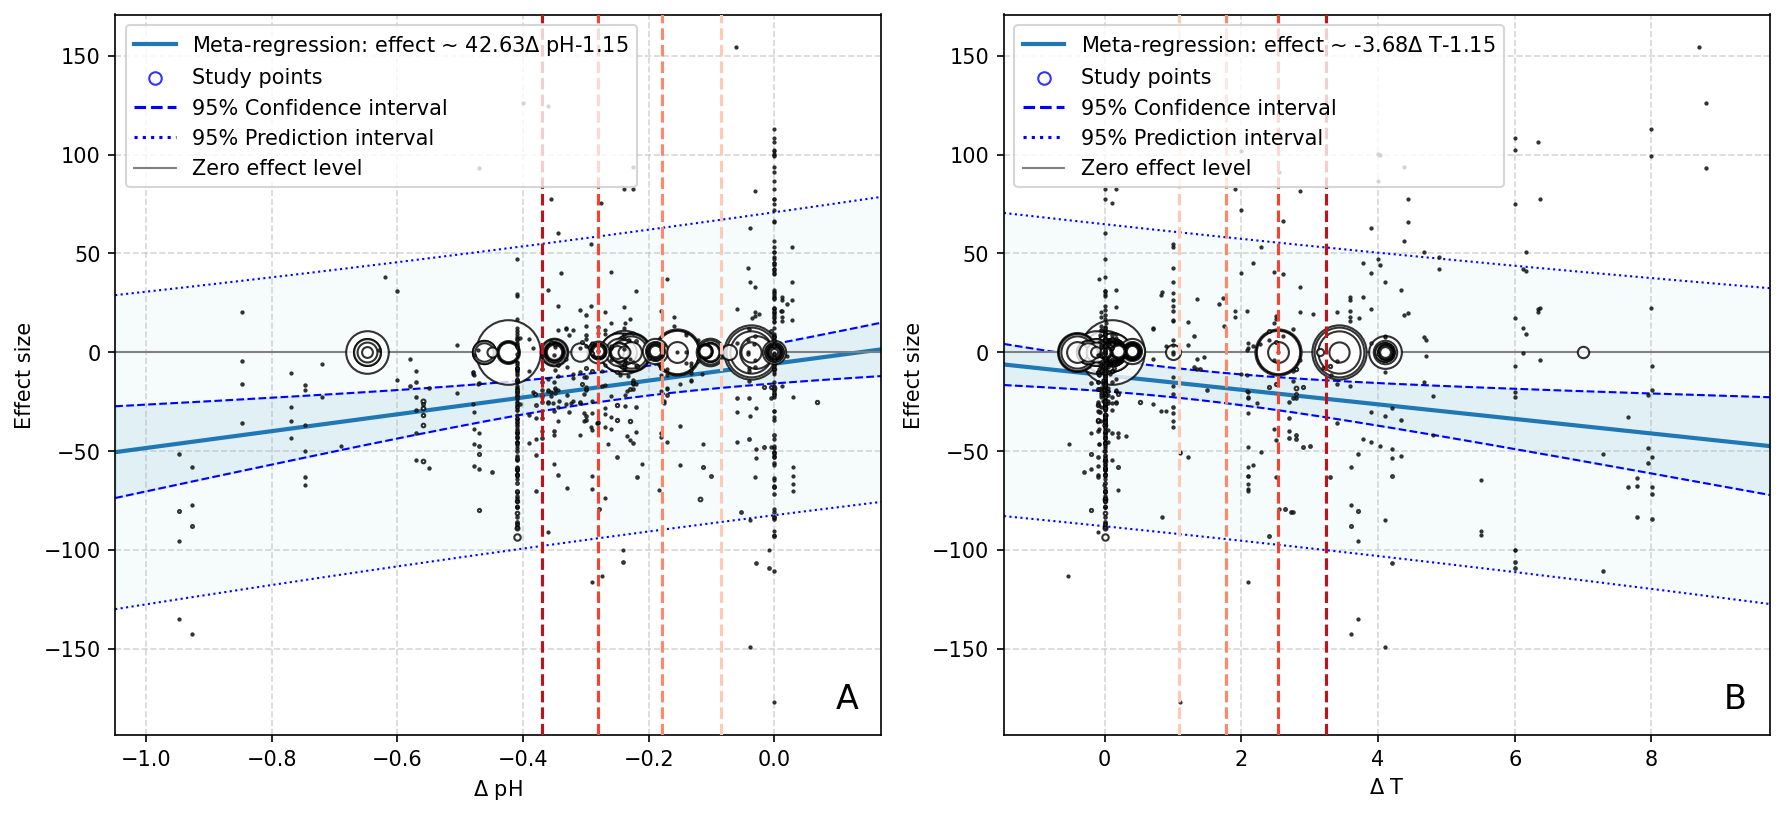

In [13]:
### CORAL
coral_model = meta_regression.MetaforModel(
    coral_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()

# plot regression
analysis_plot.plot_multiple_metaregression_axes(
    model=coral_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.





Removed 4 outlier(s) (from 161 samples) based on Cook's distance threshold of 0.22

----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  217
Total samples of relevant investigation:  161
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 4
Final sample count: 157 (56 rows dropped)


(<Figure size 1800x900 with 2 Axes>,
 array([<Axes: xlabel='$\\Delta$ pH', ylabel='Effect size'>,
        <Axes: xlabel='$\\Delta$ T', ylabel='Effect size'>], dtype=object))

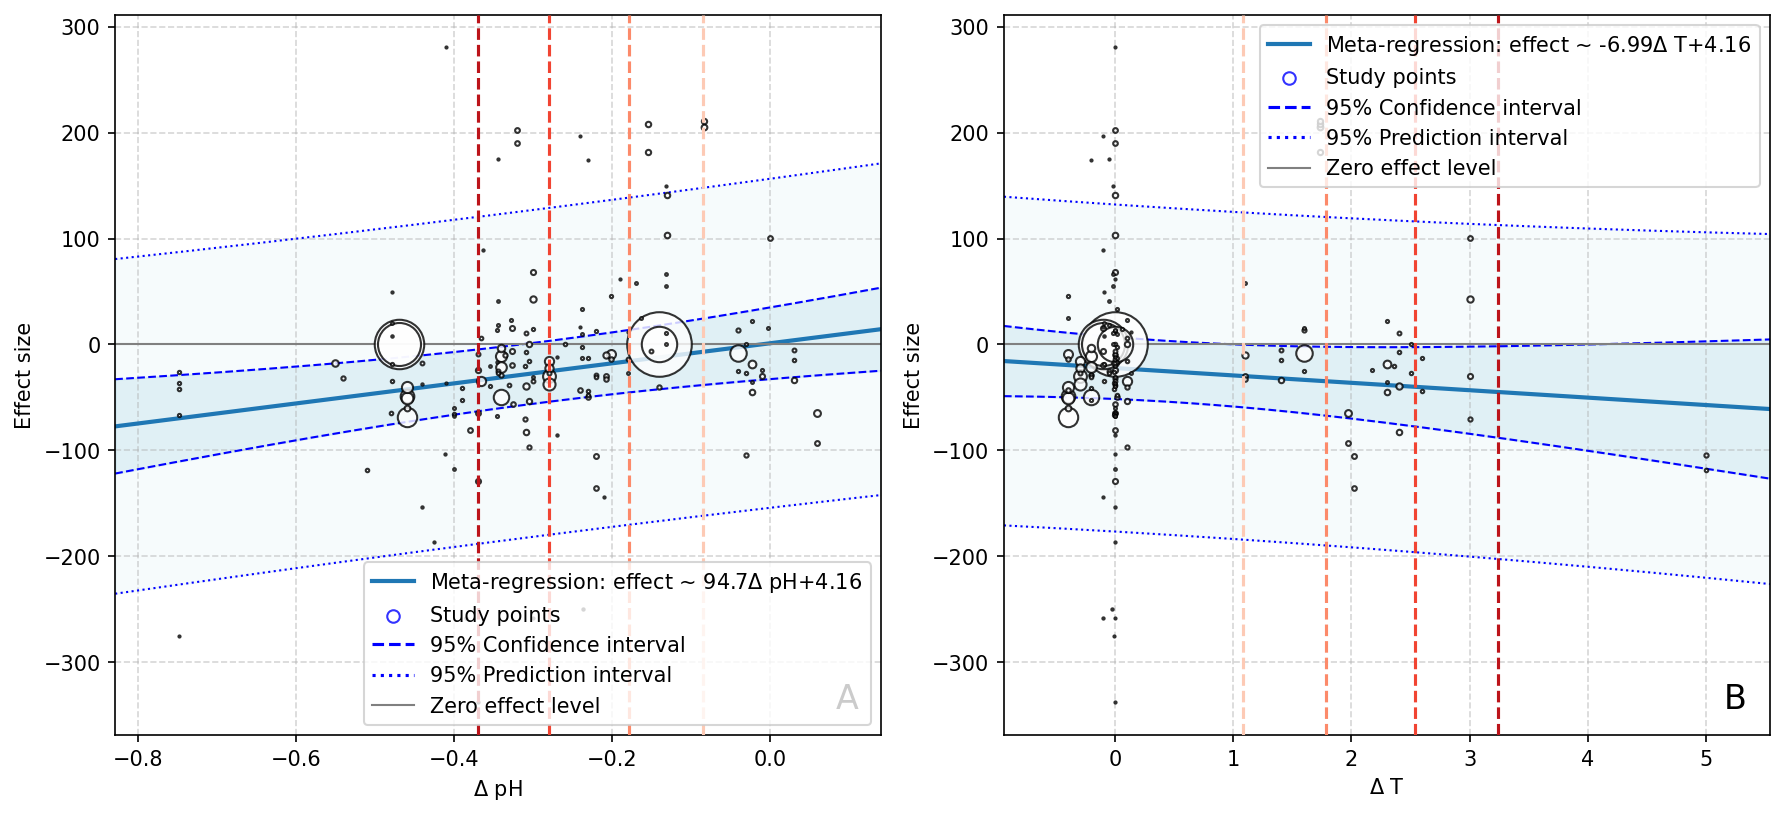

In [12]:
### CCA
cca_model = meta_regression.MetaforModel(
    cca_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()
# plot regression
analysis_plot.plot_multiple_metaregression_axes(
    model=cca_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.



Removed 1 outlier(s) (from 21 samples) based on Cook's distance threshold of 0.65

----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  31
Total samples of relevant investigation:  21
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 1
Final sample count: 20 (10 rows dropped)


(<Figure size 1800x900 with 2 Axes>,
 array([<Axes: xlabel='$\\Delta$ pH', ylabel='Effect size'>,
        <Axes: xlabel='$\\Delta$ T', ylabel='Effect size'>], dtype=object))

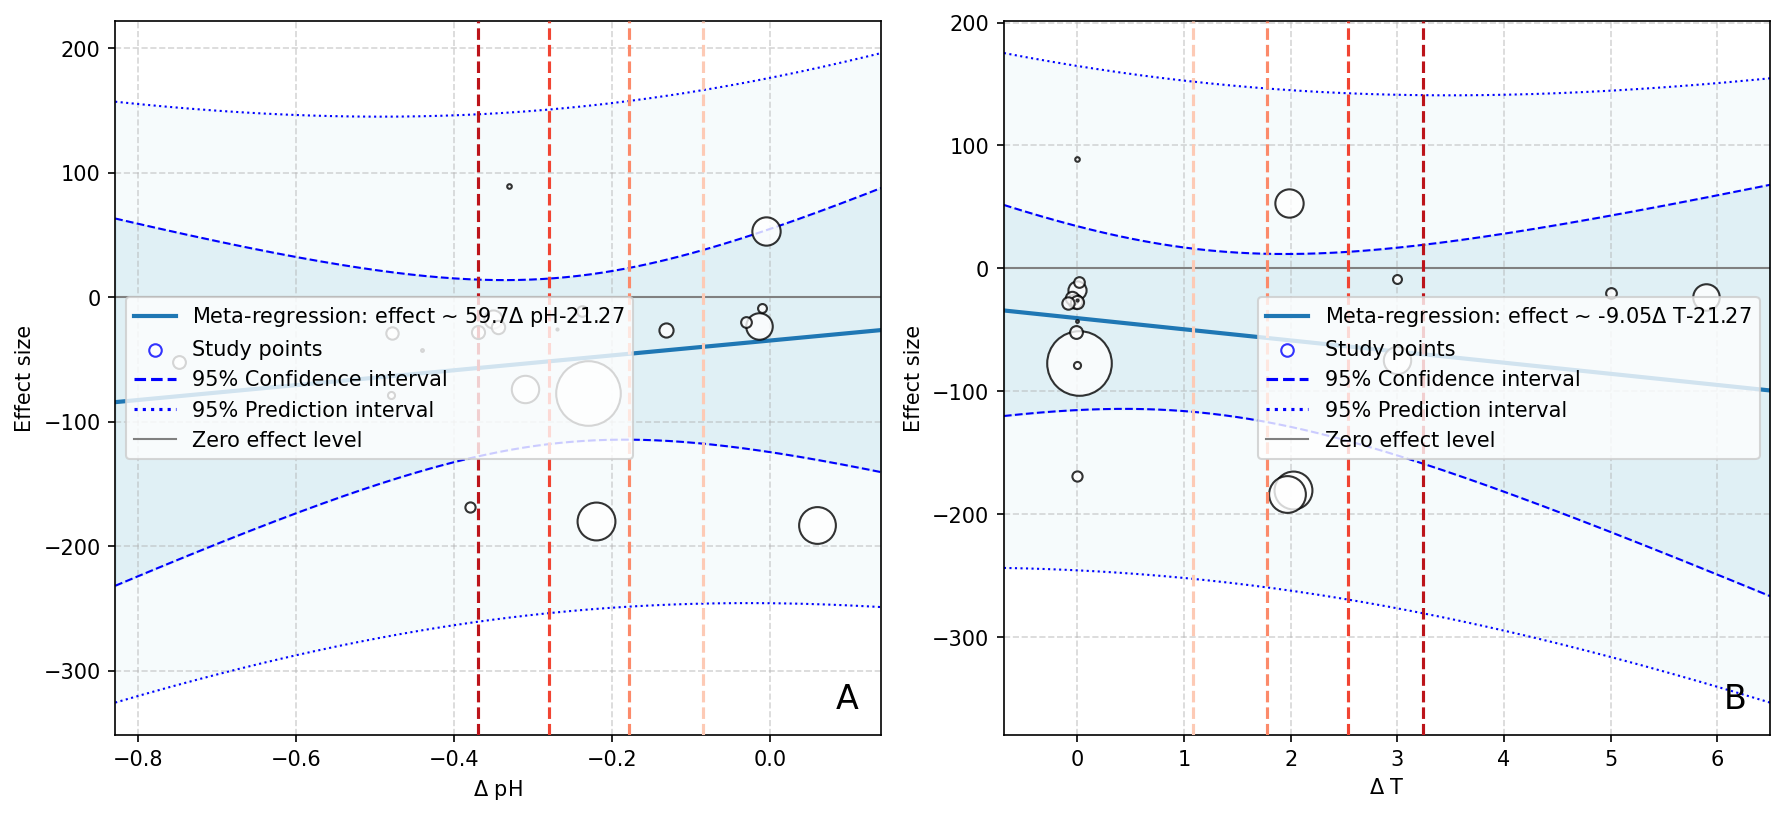

In [14]:
### OTHER ALGAE
other_algae_model = meta_regression.MetaforModel(
    other_algae_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()
# plot regression
analysis_plot.plot_multiple_metaregression_axes(
    model=other_algae_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.





Removed 2 outlier(s) (from 69 samples) based on Cook's distance threshold of 0.35

----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  115
Total samples of relevant investigation:  69
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 2
Final sample count: 67 (46 rows dropped)


(<Figure size 1800x900 with 2 Axes>,
 array([<Axes: xlabel='$\\Delta$ pH', ylabel='Effect size'>,
        <Axes: xlabel='$\\Delta$ T', ylabel='Effect size'>], dtype=object))

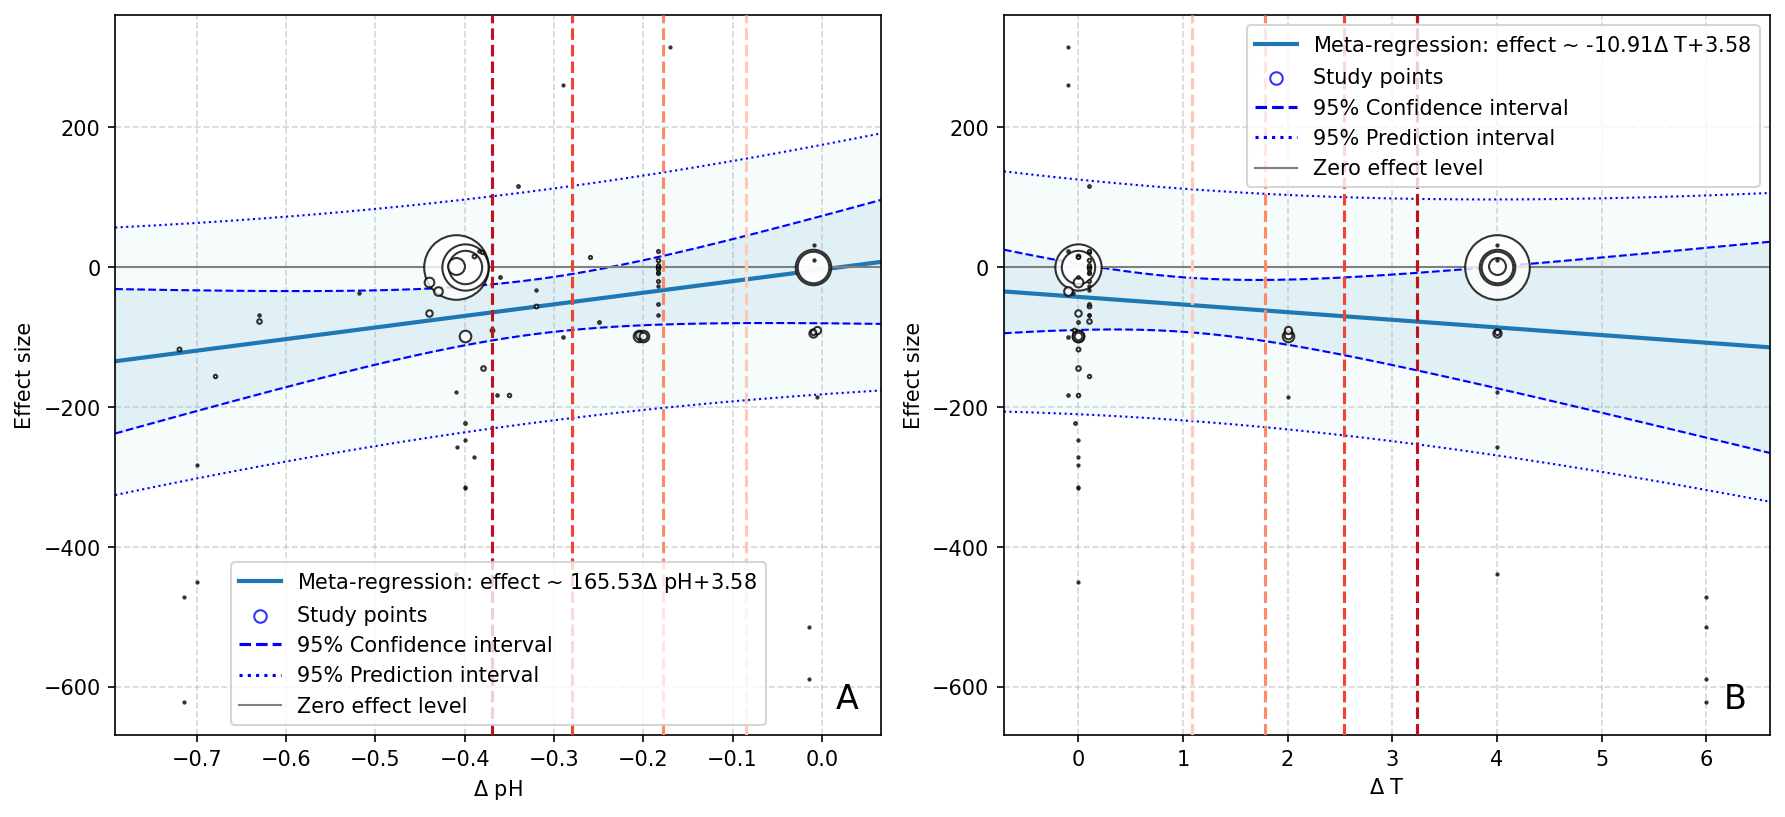

In [15]:
### HALIMEDA
halimeda_model = meta_regression.MetaforModel(
    halimeda_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()
# plot regression
analysis_plot.plot_multiple_metaregression_axes(
    model=halimeda_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)

INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.





Removed 1 outlier(s) (from 8 samples) based on Cook's distance threshold of 1.15

----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  8
Total samples of relevant investigation:  8
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 1
Final sample count: 7 (0 rows dropped)


(<Figure size 1800x900 with 2 Axes>,
 array([<Axes: xlabel='$\\Delta$ pH', ylabel='Effect size'>,
        <Axes: xlabel='$\\Delta$ T', ylabel='Effect size'>], dtype=object))

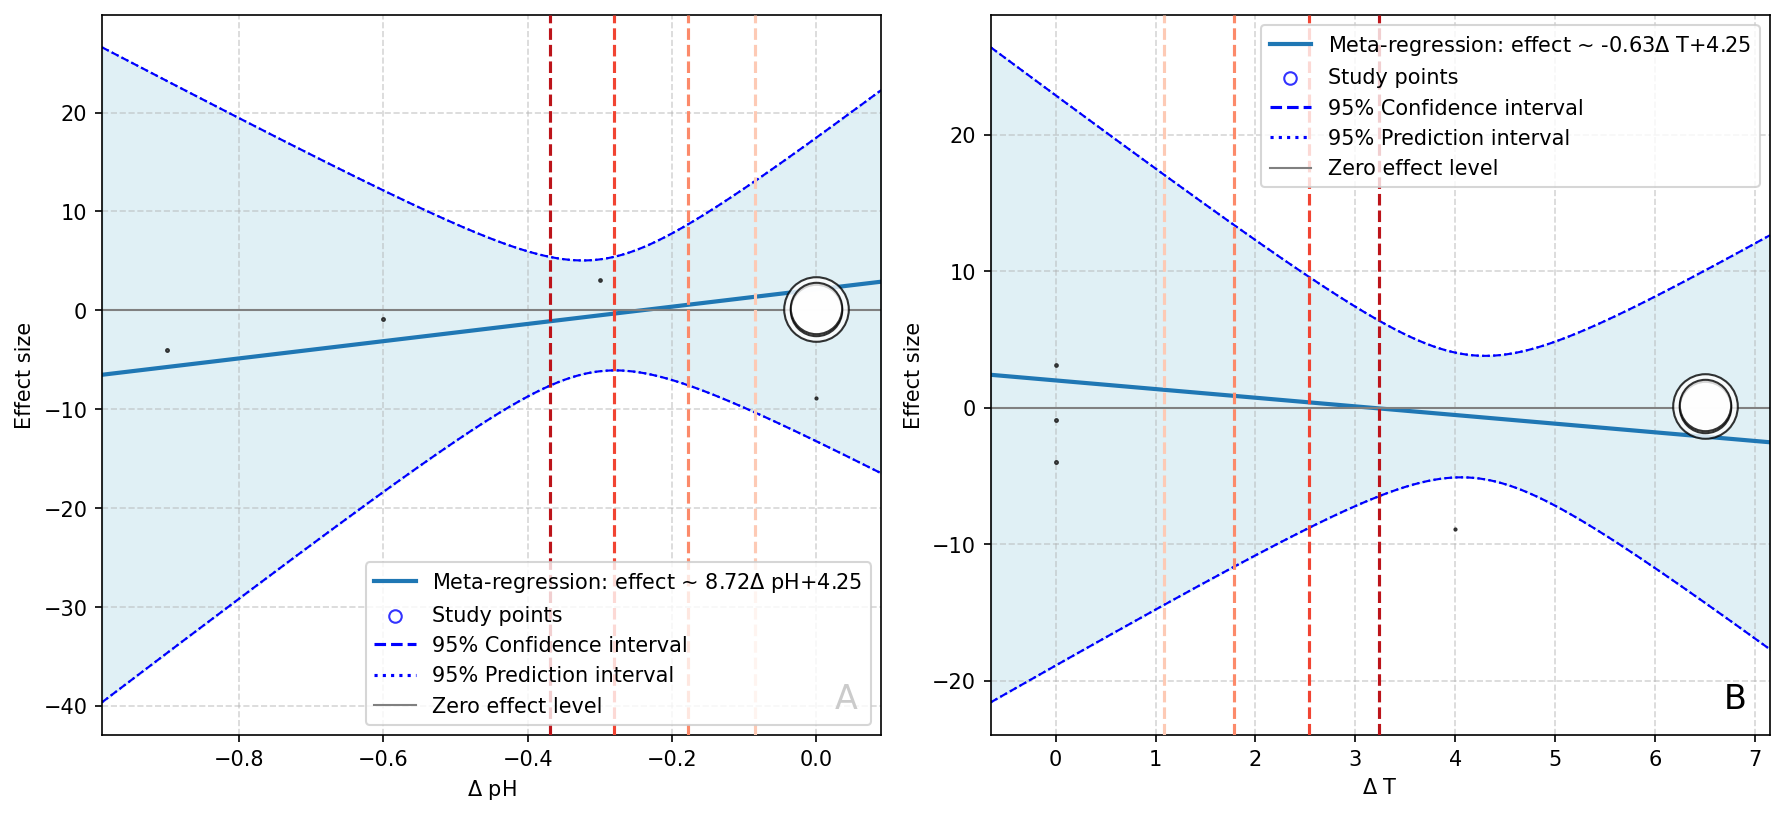

In [ ]:
### FORAMINIFERA (INSUFFICIENT DATA)
foraminifera_model = meta_regression.MetaforModel(
    foraminifera_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()
# plot regression
analysis_plot.plot_multiple_metaregression_axes(
    model=foraminifera_model.model,
    x_axis_moderators=["delta_ph", "delta_t"],
    future_global_anomaly_df=global_future_anomaly_df,
)


In [ ]:
# # TODO. What would I want this to do?
# analysis_utils.summarize_metafor_models(
#     [
#         interaction_cg_model_summary,
#         coral_model_summary,
#         cca_model_summary,
#         other_algae_model_summary,
#         halimeda_model_summary,
#     ],
#     ["all", "coral", "CCA", "Other Algae", "Halimeda"],
# )


# Additional model exploration

### ANOVA model comparison

### Temperature and/or pH as categorical variables

### Temperature and/or pH as non-linear variables

In [ ]:
effect_type = "st_relative_calcification"  # redefine: can be played around with

# assign categorial levels to delta_t: <0.5 no change, 0.5-1.5 low, 1.5-2.5 medium, >2.5 high
data_df["delta_t_category"] = data_df["delta_t"].apply(
    processing.assign_delta_t_category
)
print(data_df["delta_t_category"].value_counts())

# process single_control_df for r
single_control_df = data_df[
    data_df["treatment"].isin(["phtot", "temp", "phtot_temp_mv"])
].copy()
df_r_ready = analysis.process_df_for_r(single_control_df)

# Convert pandas dataframe to R dataframe
r_data = pandas2ri.py2rpy(df_r_ready)

### Initialisation and ANOVAs

In [26]:
### INITIAL NAIVE MODELS

model1 = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph + delta_t",
    # verbose=False,
).fit_model()
model2 = meta_regression.MetaforModel(
    data_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
).fit_model()
# model3 = meta_regression.MetaforModel(
#     data_df,
#     effect_type=effect_type,
#     treatment=["phtot", "temp", "phtot_temp_mv"],
#     formula=f"{effect_type} ~ factor(core_grouping)",
# ).fit_model()
# model4 = meta_regression.MetaforModel(
#     data_df,
#     effect_type=effect_type,
#     treatment=["phtot", "temp", "phtot_temp_mv"],
#     formula=f"{effect_type} ~ factor(core_grouping) + delta_ph",
# ).fit_model()
# model5 = meta_regression.MetaforModel(
#     data_df,
#     effect_type=effect_type,
#     treatment=["phtot", "temp", "phtot_temp_mv"],
#     formula=f"{effect_type} ~ factor(core_grouping) + delta_t",
# ).fit_model()
# model6 = meta_regression.MetaforModel(
#     data_df,
#     effect_type=effect_type,
#     treatment=["phtot", "temp", "phtot_temp_mv"],
#     formula=f"{effect_type} ~ factor(core_grouping) + delta_ph + delta_t",
# ).fit_model(verbose=False)
# model7 = meta_regression.MetaforModel(
#     data_df,
#     effect_type=effect_type,
#     treatment=["phtot", "temp", "phtot_temp_mv"],
#     formula=f"{effect_type} ~ factor(core_grouping) + delta_ph * delta_t",
# ).fit_model()

INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph + delta_t



Removed 13 outlier(s) (from 942 samples) based on Cook's distance threshold of 0.11

----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  1239
Total samples of relevant investigation:  942
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 13
Final sample count: 929 (297 rows dropped)


INFO:calcification.analysis.meta_regression:Model fitting complete.
INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t



Removed 14 outlier(s) (from 942 samples) based on Cook's distance threshold of 0.09

----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  1239
Total samples of relevant investigation:  942
Dropped due to NaN values in required columns: 0
Dropped due to Cook's distance: 14
Final sample count: 928 (297 rows dropped)


INFO:calcification.analysis.meta_regression:Model fitting complete.


In [27]:
import rpy2

metafor = rpy2.robjects.packages.importr("metafor")
### experimental anovas
# anova_add_int = metafor.anova_rma(model1.model, model2.model)  # additive vs interactive
# TODO: can't compare since k different by 1 due to Cook's distance filtering

## Predicting on climate anomalies

(<Figure size 2700x750 with 2 Axes>,
 array([<Axes: xlabel='Year'>, <Axes: xlabel='Year'>], dtype=object))

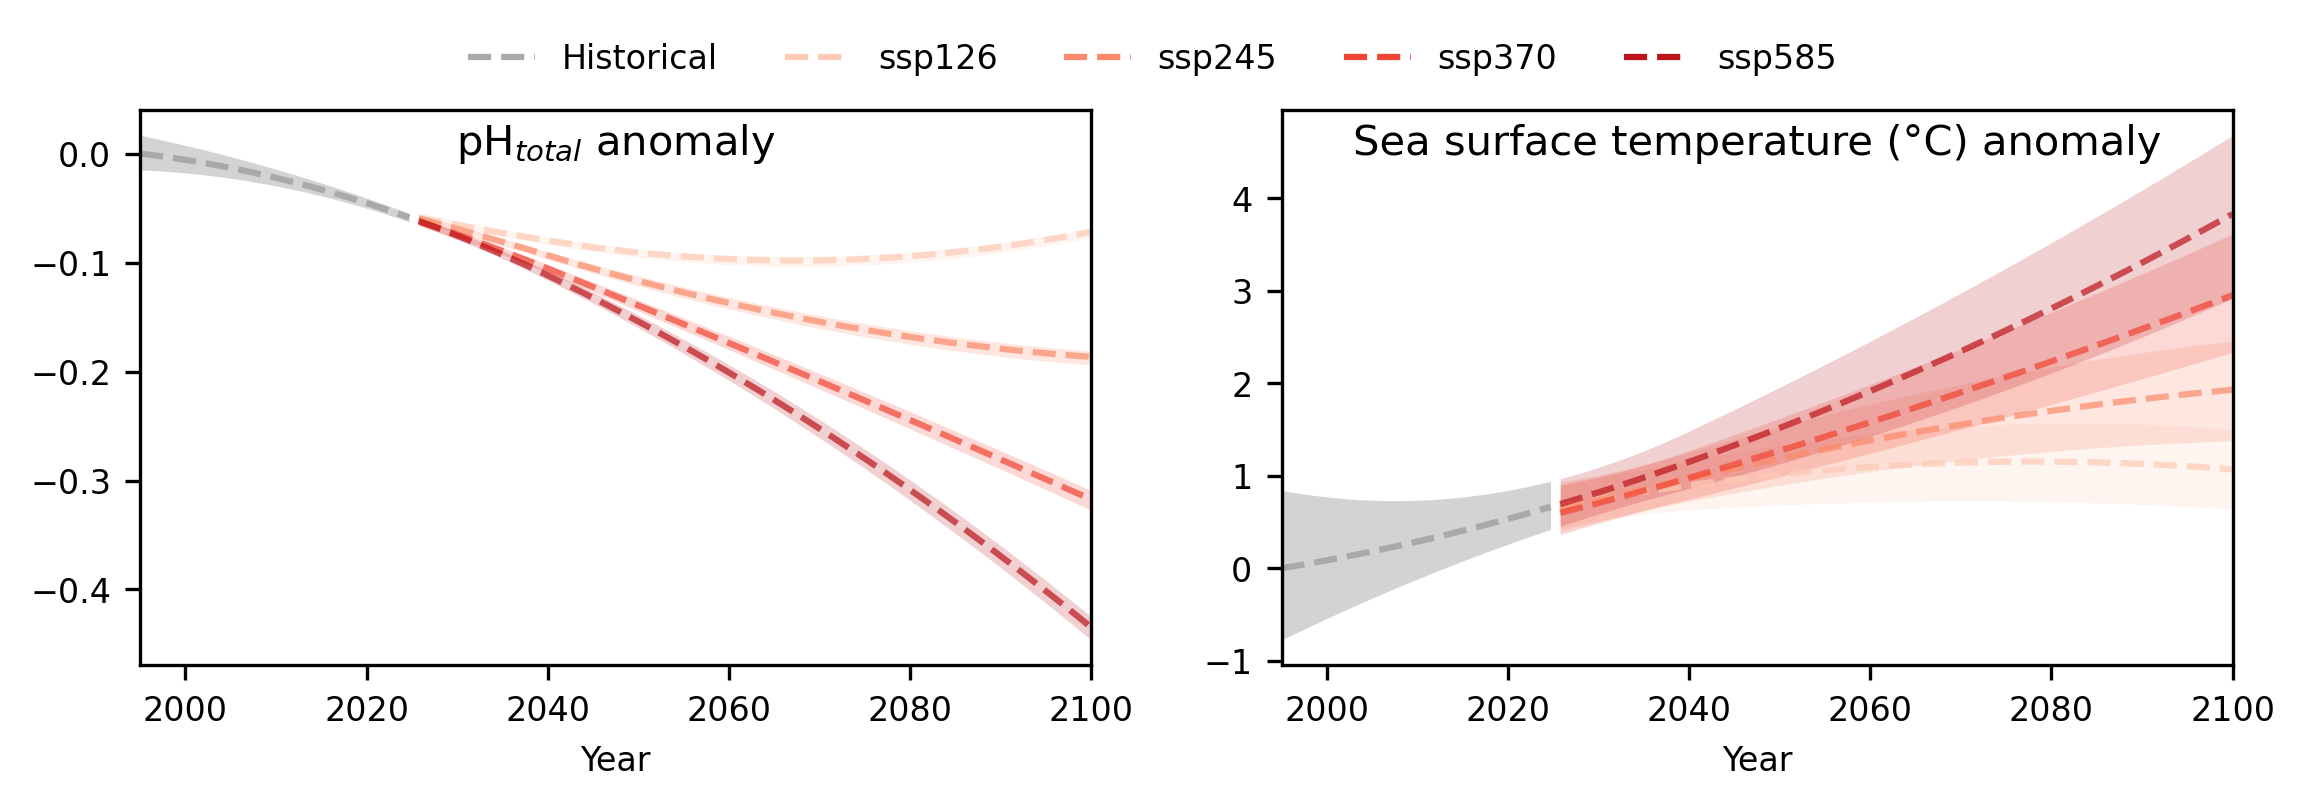

In [82]:
### plot temporal anomalies
climatology.plot_climate_anomalies(
    global_anomaly_df,
    plot_vars=["ph", "sst"],
    figsize=(9, 2.5),
    dpi=300,
)

INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.




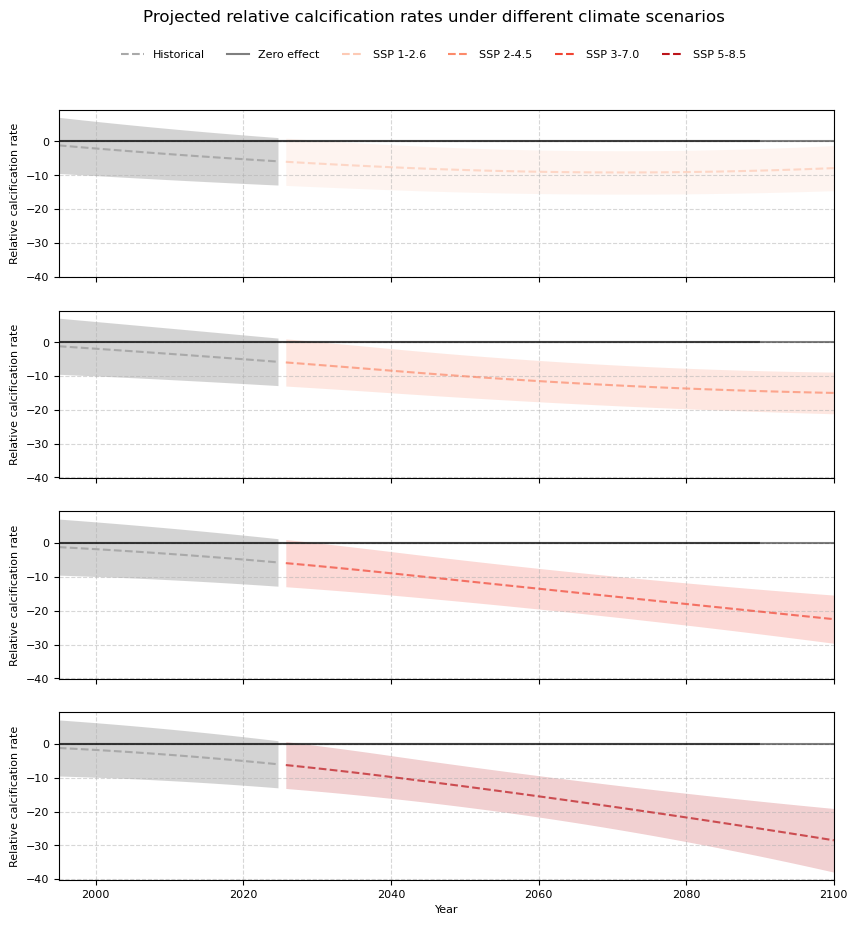

In [ ]:
### CORAL
coral_model = meta_regression.MetaforModel(
    coral_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
    verbose=False,
).fit_model()

coral_prediction_df = meta_regression.prediction_df_from_model(
    coral_model.model,
    ["delta_ph", "delta_t"],
    global_anomaly_df[["anomaly_value_ph", "anomaly_value_sst"]].values.T,
    npoints=len(global_anomaly_df),
)

climatology.plot_global_timeseries(
    pd.concat([global_anomaly_df, coral_prediction_df], axis=1)
);


INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.




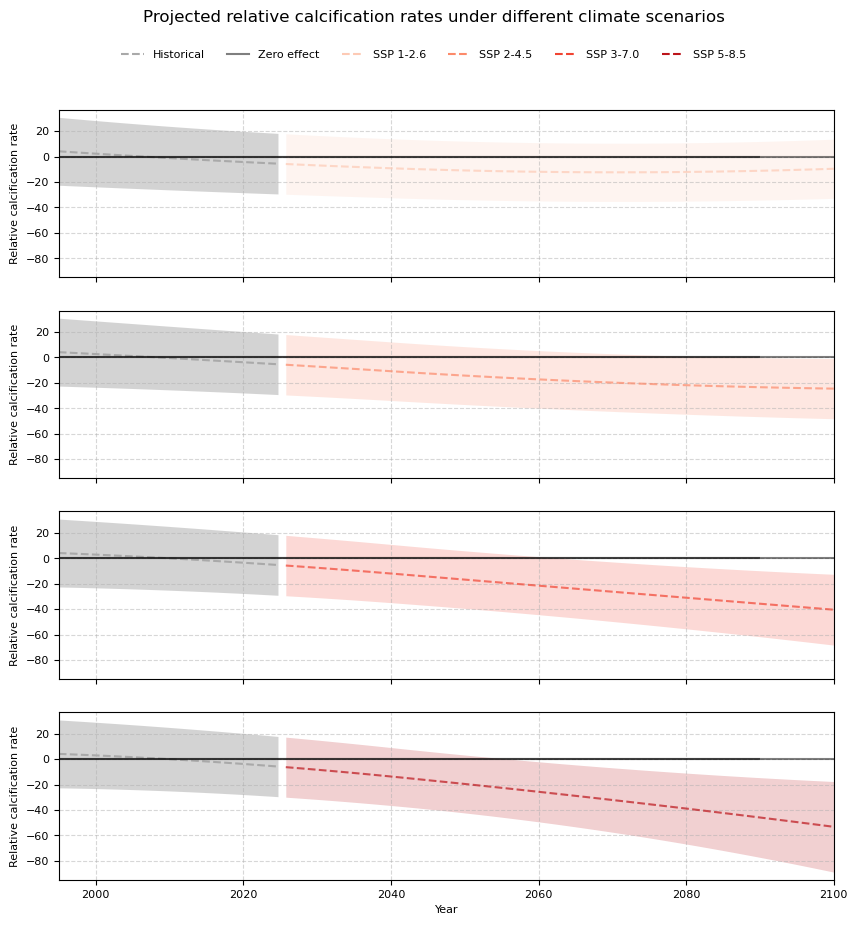

In [ ]:
### CCA
cca_model = meta_regression.MetaforModel(
    cca_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
    verbose=False,
).fit_model()

cca_prediction_df = meta_regression.prediction_df_from_model(
    cca_model.model,
    ["delta_ph", "delta_t"],
    global_anomaly_df[["anomaly_value_ph", "anomaly_value_sst"]].values.T,
    npoints=len(global_anomaly_df),
)

climatology.plot_global_timeseries(
    pd.concat([global_anomaly_df, cca_prediction_df], axis=1)
);


INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.


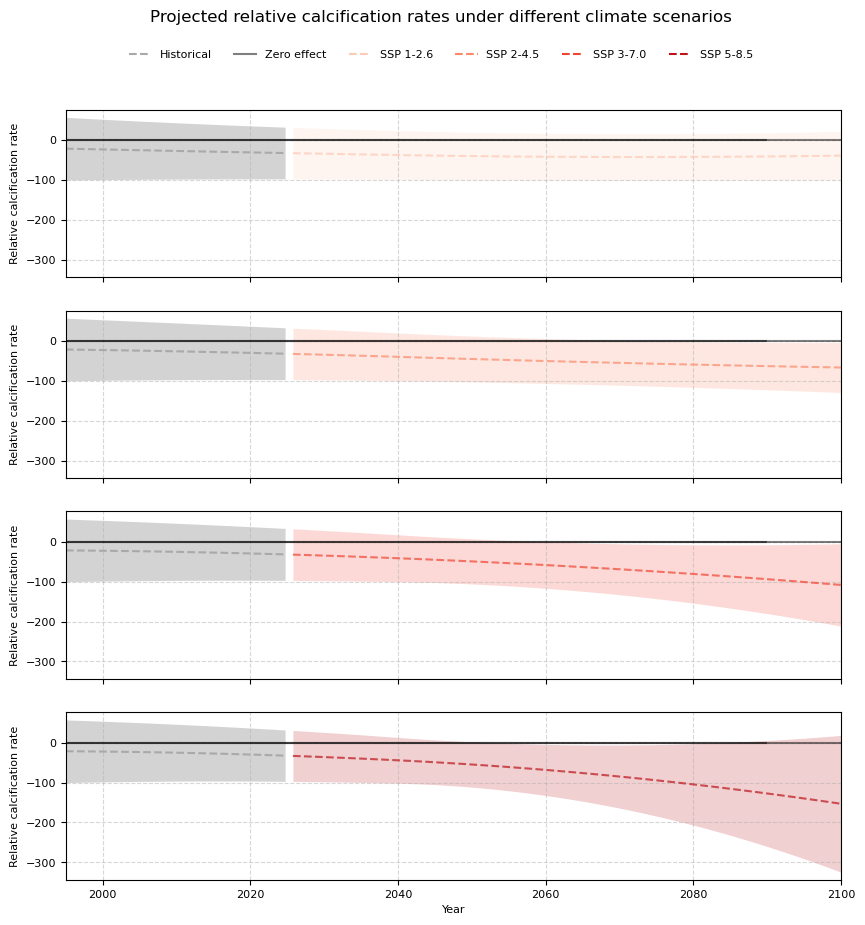

In [85]:
### OTHER ALGAE
other_algae_model = meta_regression.MetaforModel(
    other_algae_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
    verbose=False,
).fit_model()

other_algae_prediction_df = meta_regression.prediction_df_from_model(
    other_algae_model.model,
    ["delta_ph", "delta_t"],
    global_anomaly_df[["anomaly_value_ph", "anomaly_value_sst"]].values.T,
    npoints=len(global_anomaly_df),
)

climatology.plot_global_timeseries(
    pd.concat([global_anomaly_df, other_algae_prediction_df], axis=1)
);


INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.




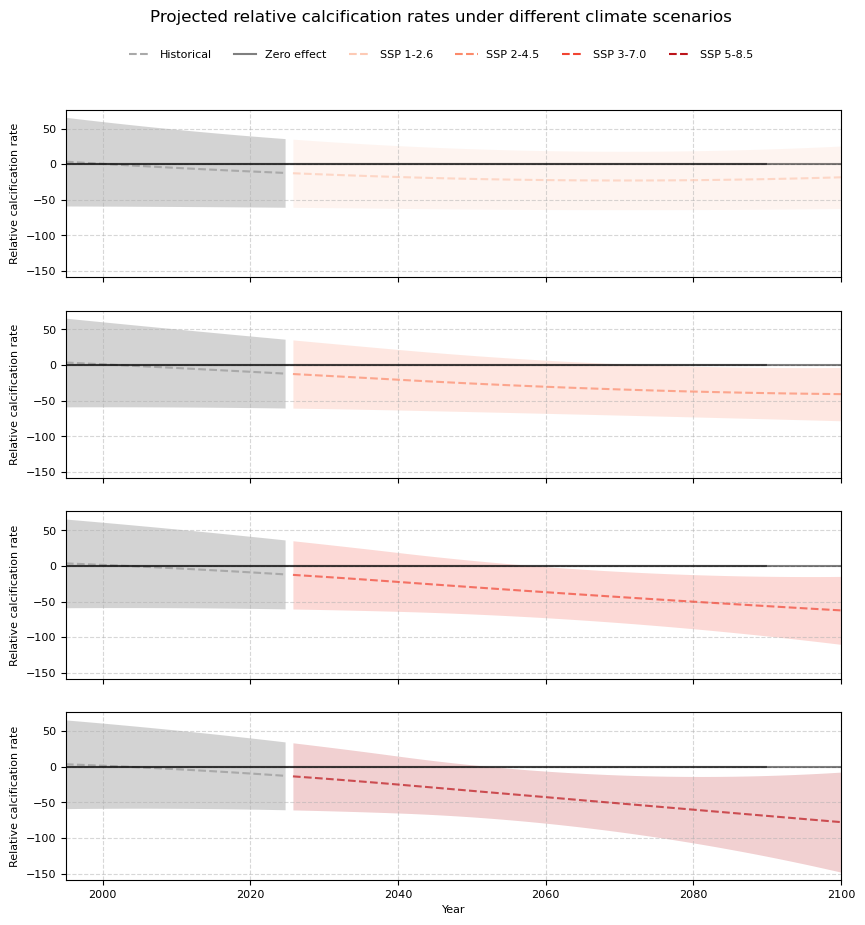

In [86]:
### HALIMEDA
halimeda_model = meta_regression.MetaforModel(
    halimeda_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
    verbose=False,
).fit_model()

halimeda_prediction_df = meta_regression.prediction_df_from_model(
    halimeda_model.model,
    ["delta_ph", "delta_t"],
    global_anomaly_df[["anomaly_value_ph", "anomaly_value_sst"]].values.T,
    npoints=len(global_anomaly_df),
)

climatology.plot_global_timeseries(
    pd.concat([global_anomaly_df, halimeda_prediction_df], axis=1)
);


INFO:root:Fitting metafor model with formula: st_relative_calcification ~ delta_ph * delta_t
INFO:calcification.analysis.meta_regression:Model fitting complete.




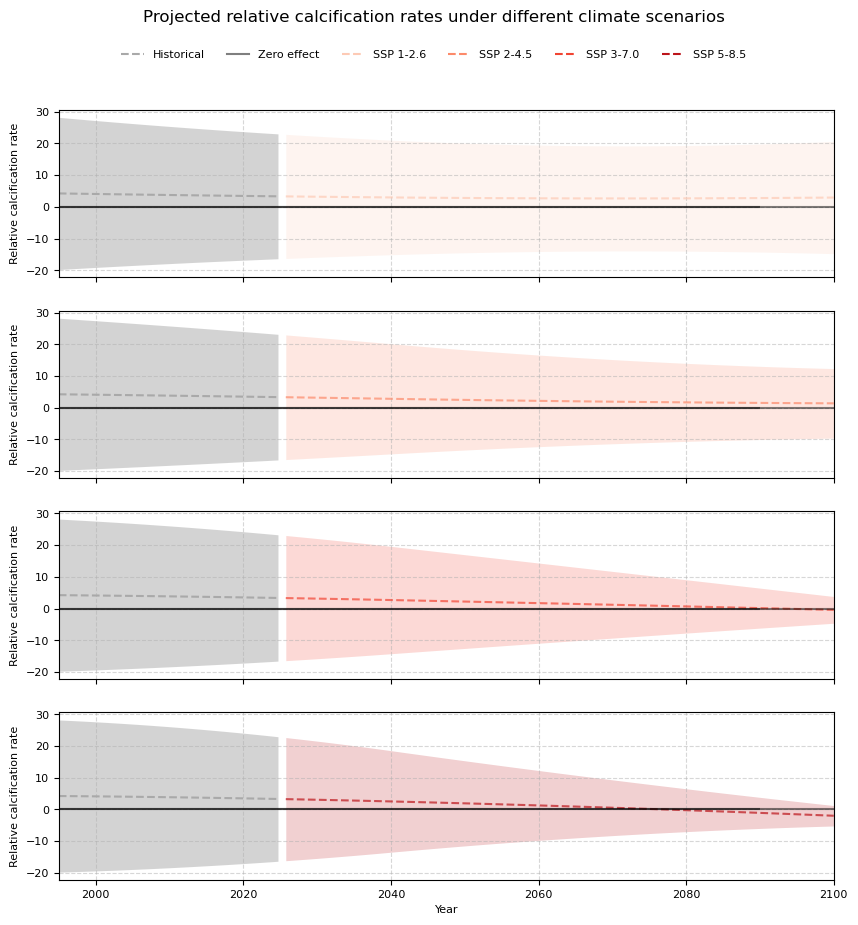

In [87]:
### FORAMINIFERA
foraminifera_model = meta_regression.MetaforModel(
    foraminifera_effects_df,
    effect_type=effect_type,
    treatment=["phtot", "temp", "phtot_temp_mv"],
    formula=f"{effect_type} ~ delta_ph * delta_t",
    verbose=False,
).fit_model()

foraminifera_prediction_df = meta_regression.prediction_df_from_model(
    foraminifera_model.model,
    ["delta_ph", "delta_t"],
    global_anomaly_df[["anomaly_value_ph", "anomaly_value_sst"]].values.T,
    npoints=len(global_anomaly_df),
)

climatology.plot_global_timeseries(
    pd.concat([global_anomaly_df, foraminifera_prediction_df], axis=1)
);


(<Figure size 3000x3000 with 4 Axes>,
 array([<Axes: ylabel='Relative calcification rate'>,
        <Axes: ylabel='Relative calcification rate'>,
        <Axes: ylabel='Relative calcification rate'>,
        <Axes: xlabel='Year', ylabel='Relative calcification rate'>],
       dtype=object))

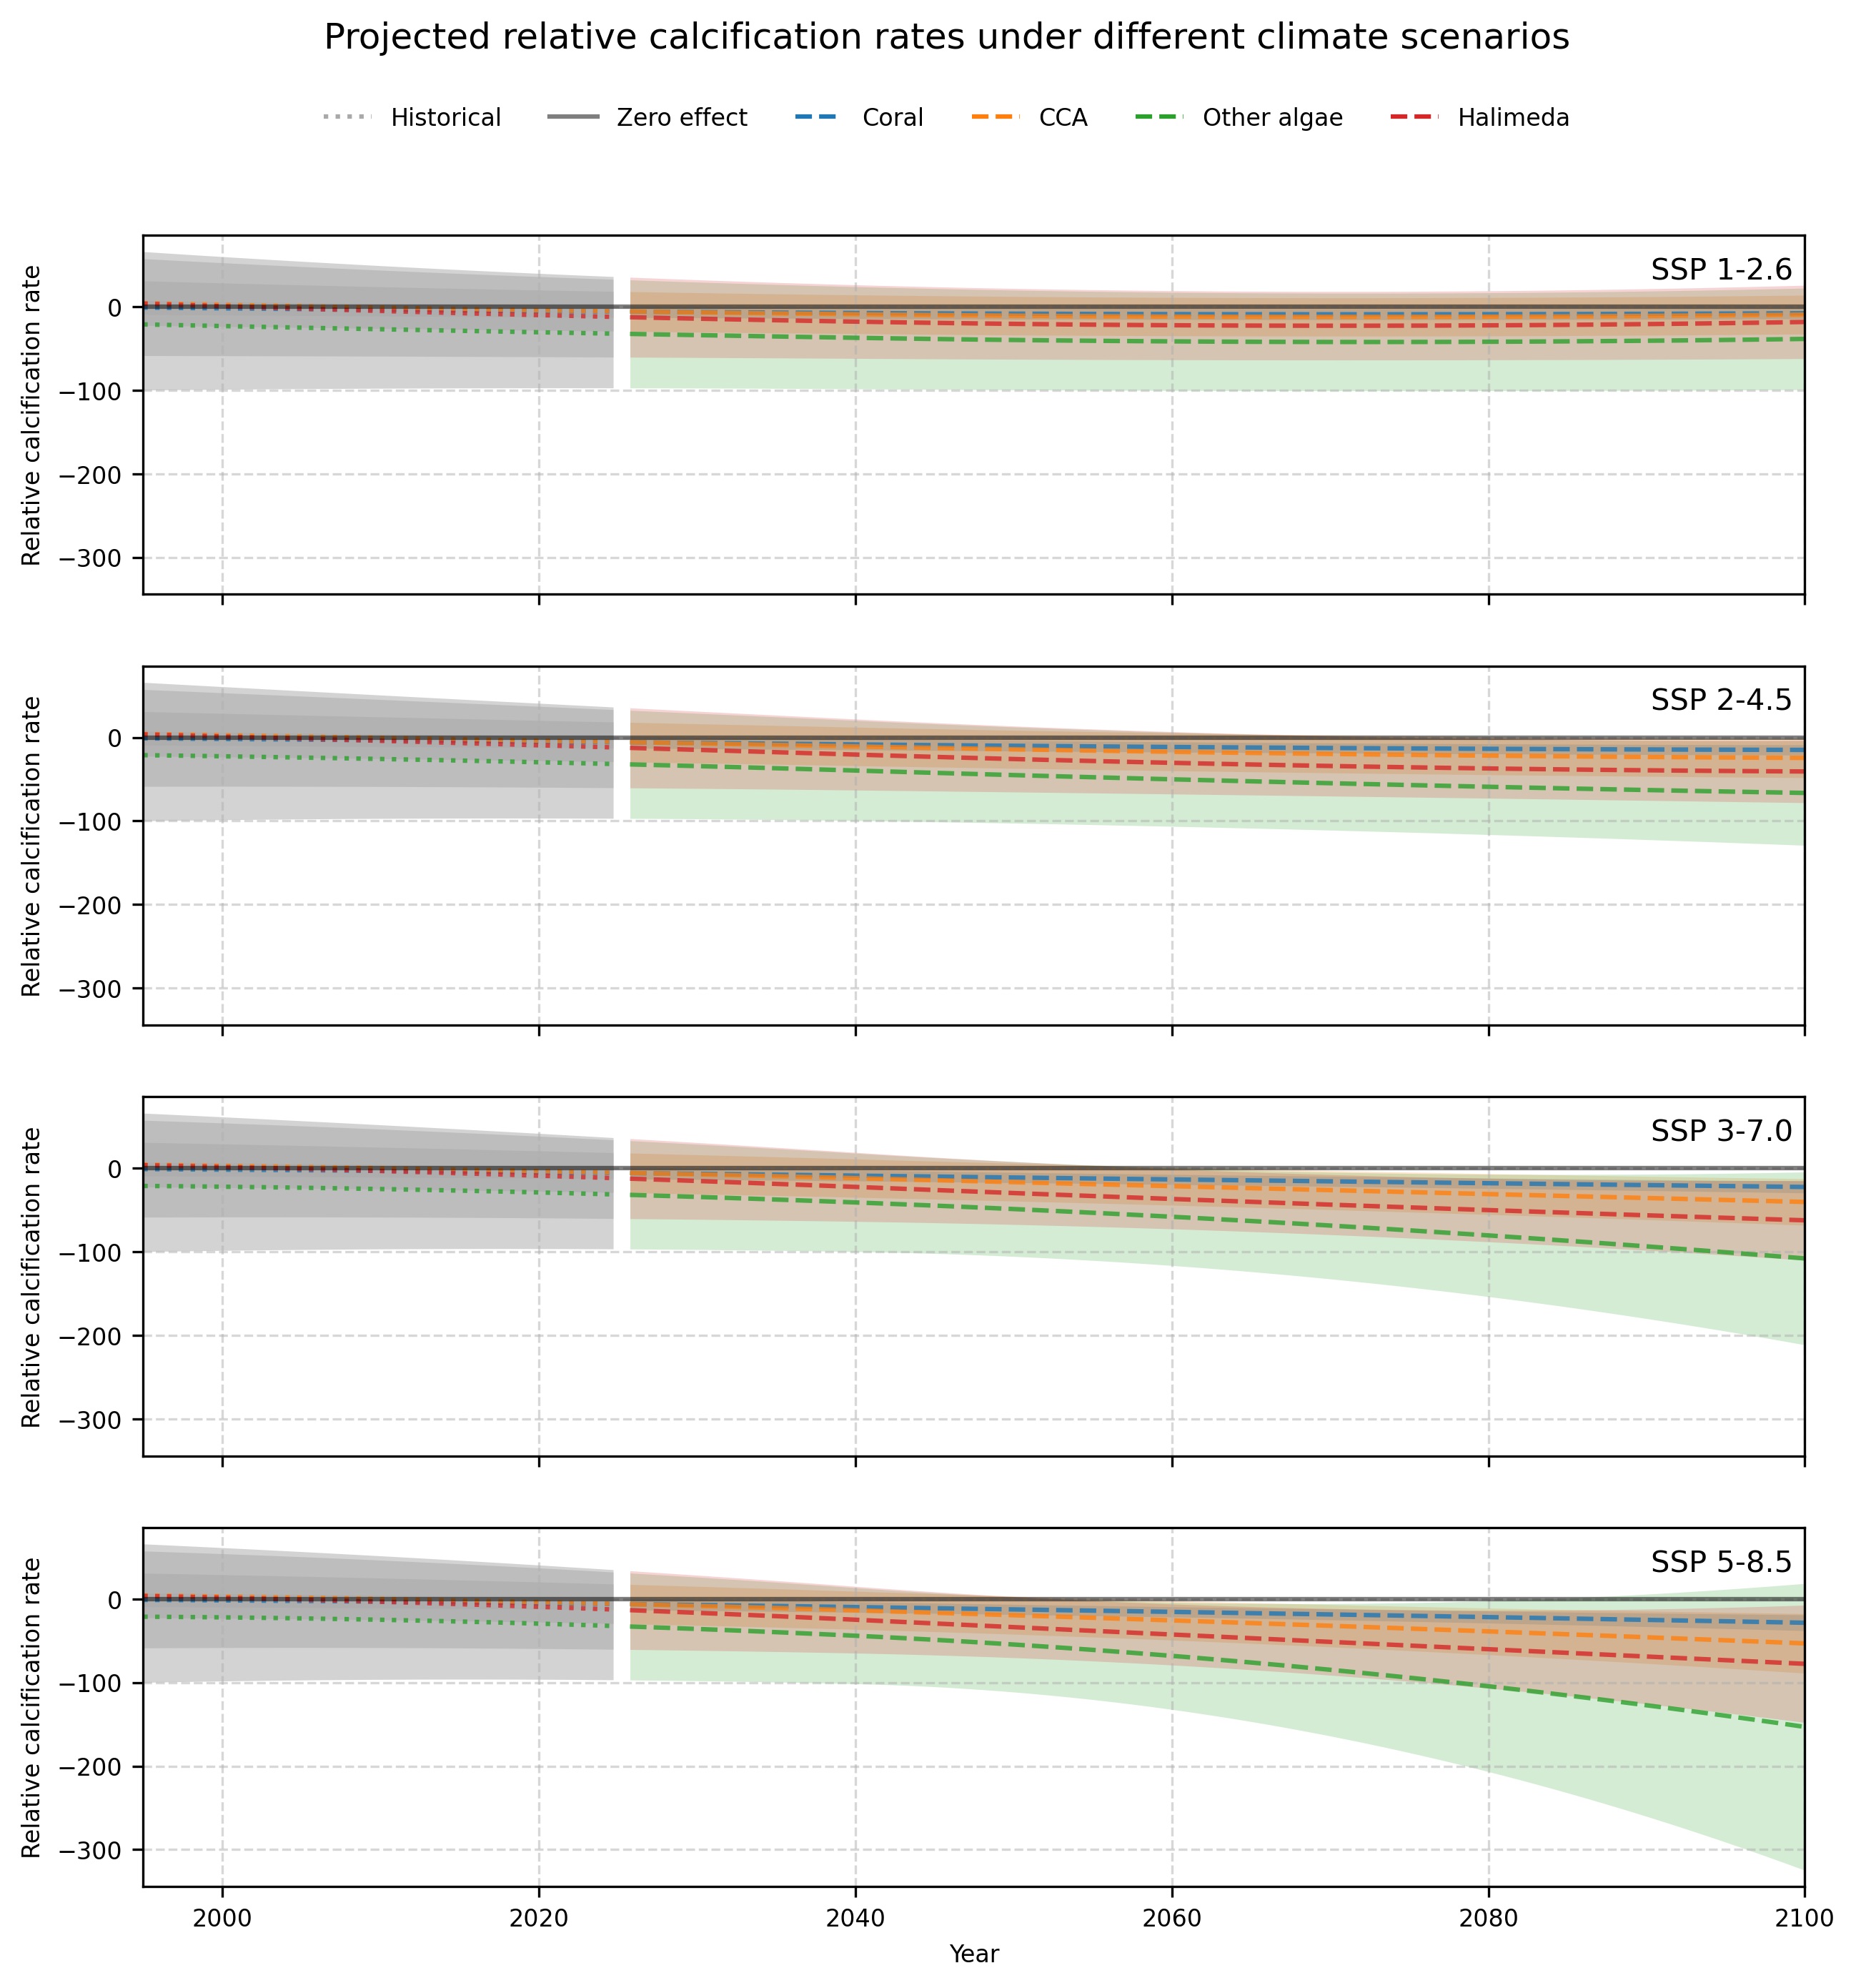

In [ ]:
analysis_plot.plot_global_timeseries_multi(
    groups={
        "Coral": pd.concat([global_anomaly_df, coral_prediction_df], axis=1),
        "CCA": pd.concat([global_anomaly_df, cca_prediction_df], axis=1),
        "Other algae": pd.concat(
            [global_anomaly_df, other_algae_prediction_df], axis=1
        ),
        "Halimeda": pd.concat([global_anomaly_df, halimeda_prediction_df], axis=1),
    },
    figsize=(10, 10),
    dpi=300,
)


In [89]:
predictions_bioerosion_df = pd.read_csv(
    config.tmp_data_dir / "bioerosion_predictions.csv"
)

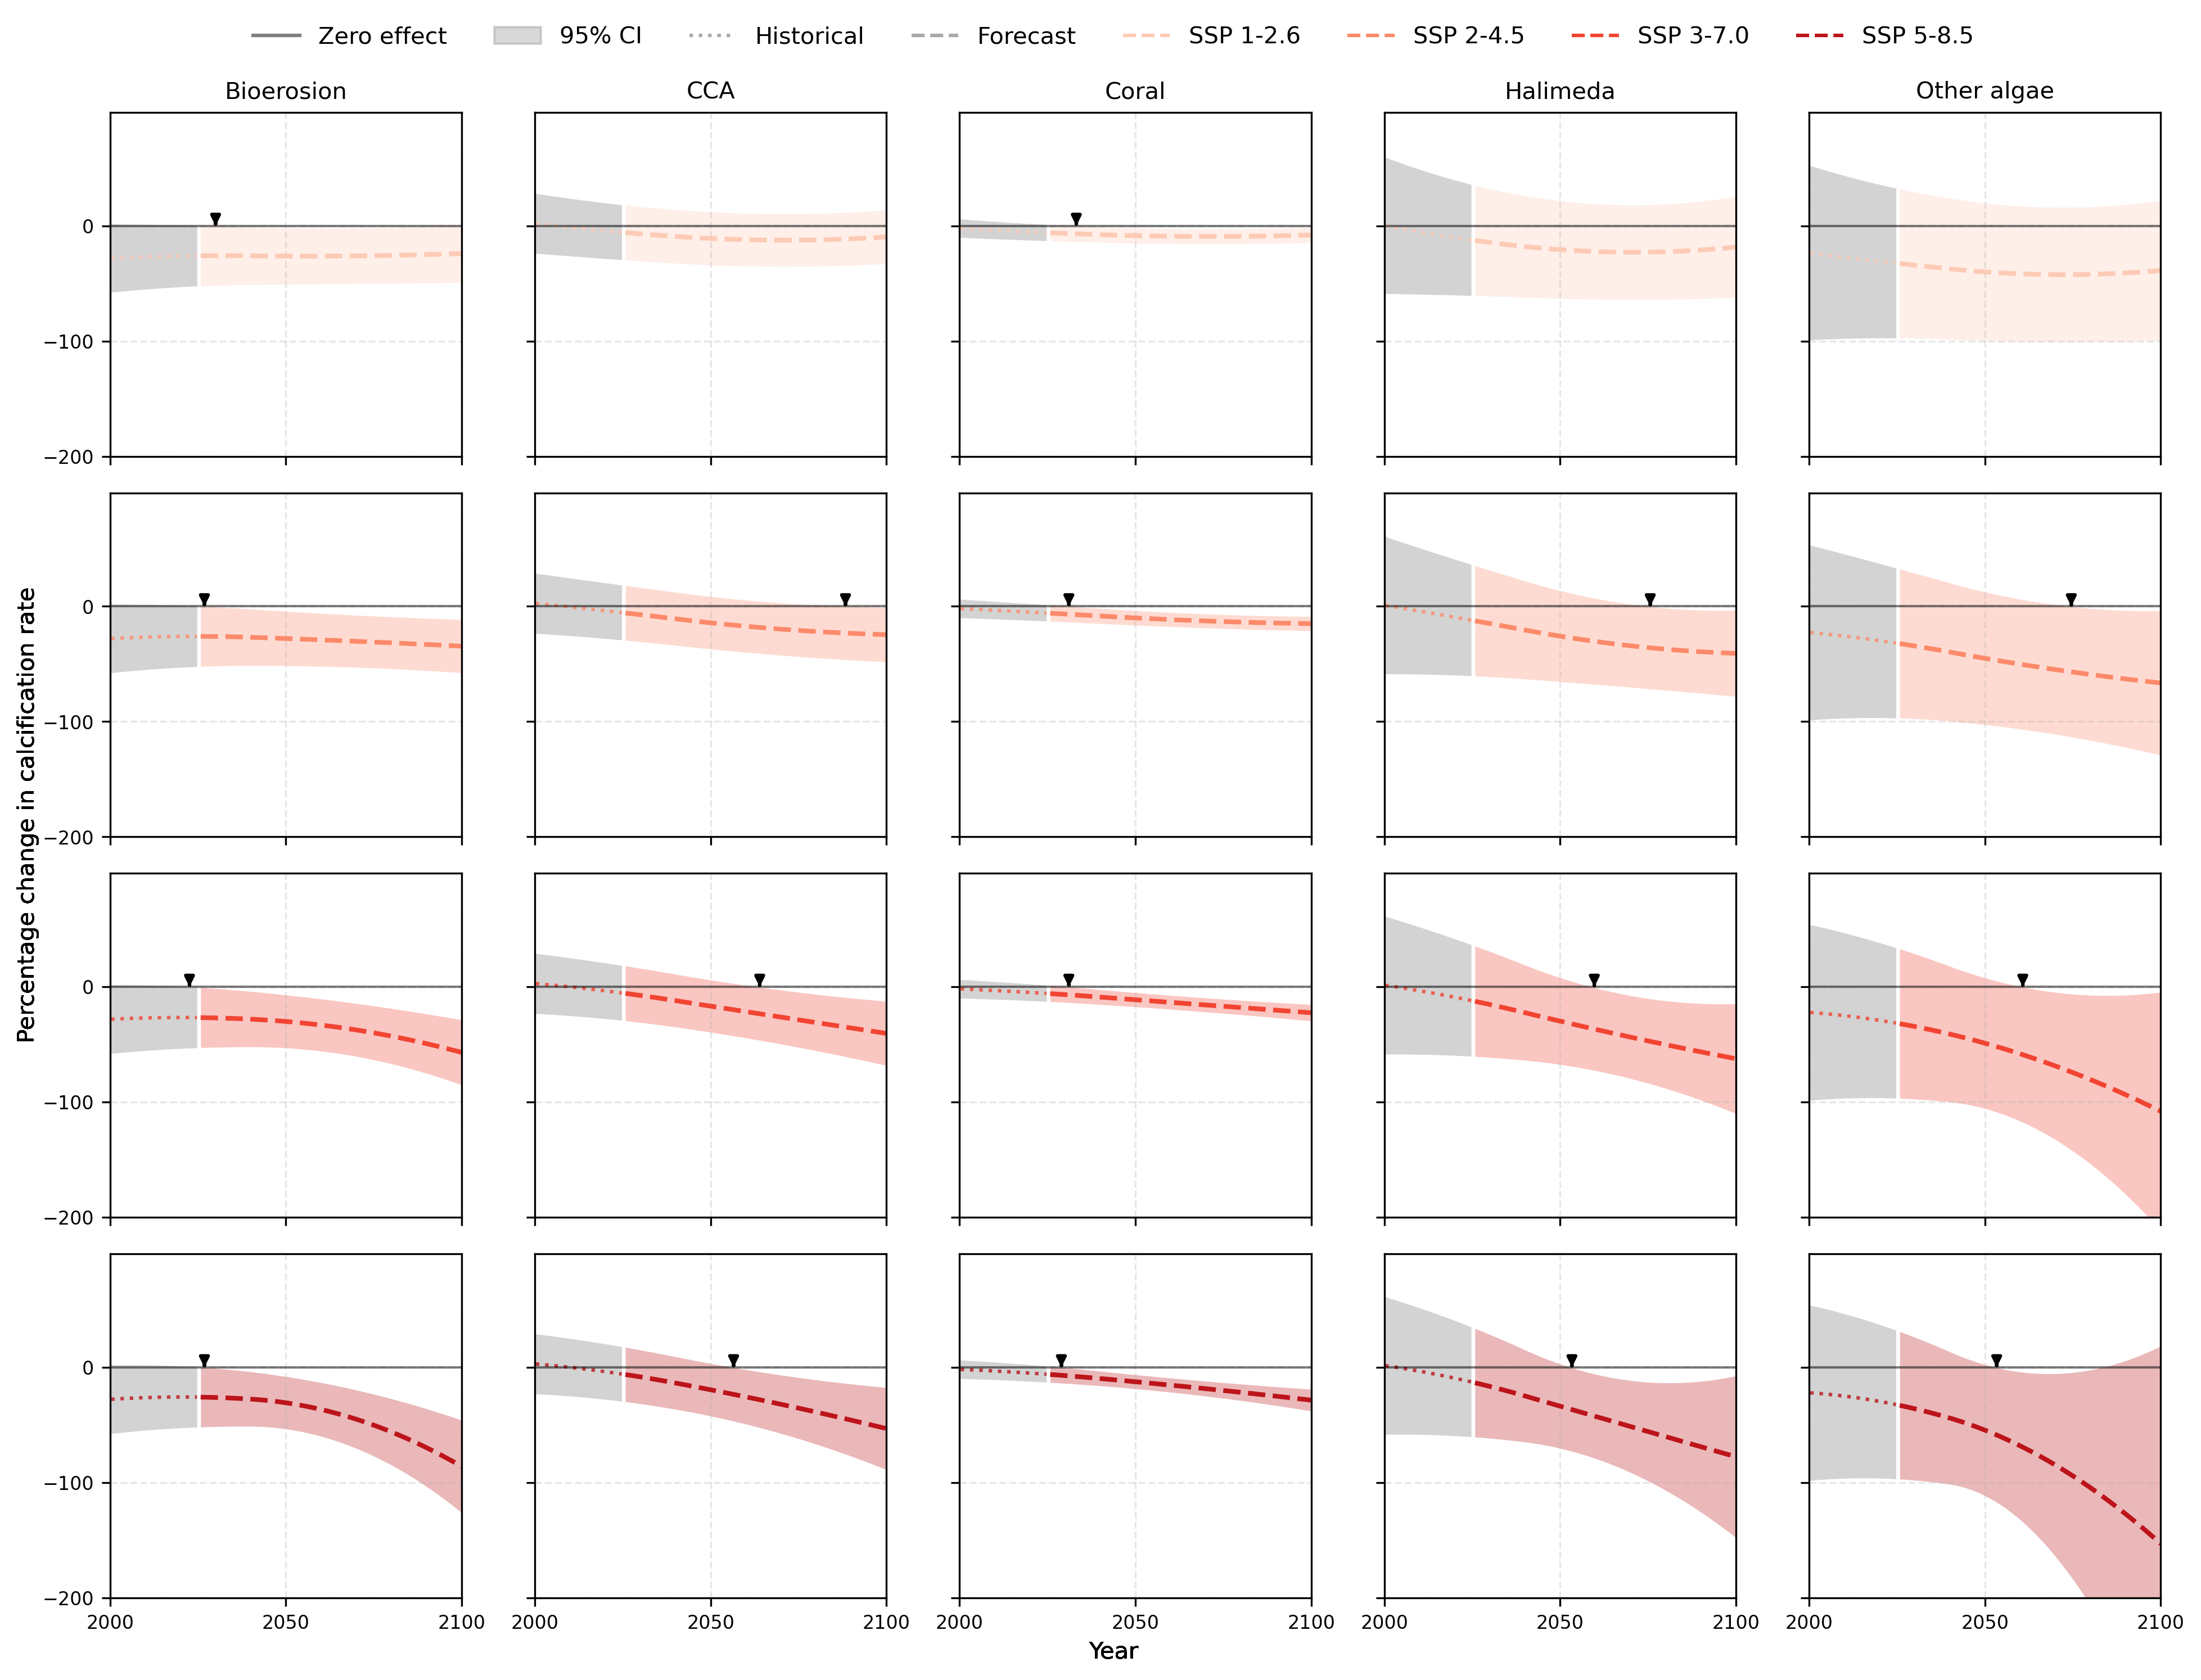

In [ ]:
# Call the function with your data
fig, axes = analysis_plot.plot_global_timeseries_grid(
    groups={
        "Bioerosion": predictions_bioerosion_df,
        "CCA": pd.concat([global_anomaly_df, cca_prediction_df], axis=1),
        "Coral": pd.concat([global_anomaly_df, coral_prediction_df], axis=1),
        "Halimeda": pd.concat([global_anomaly_df, halimeda_prediction_df], axis=1),
        "Other algae": pd.concat(
            [global_anomaly_df, other_algae_prediction_df], axis=1
        ),
    },
    figsize=(13, 10),
    dpi=300,
)

plt.show()

# Burning embers plots

#### General processing

In [ ]:
# TODO: finish plotting this
### combine all predictions into a single dataframe
join_cols = [
    "scenario",
    "time_frame",
    "percentile",
    "anomaly_value_ph",
    "anomaly_value_sst",
]

all_preds_df = predictions_coral_df[join_cols].copy()
for predictions_df, core_grouping in zip(
    [
        predictions_coral_df,
        predictions_cca_df,
        predictions_other_algae_df,
        predictions_halimeda_df,
    ],
    ["Coral", "CCA", "Other algae", "Halimeda"],
):
    # append "_{core_grouping}" to the column names in predictions_df which are not in join_cols
    predictions_df = predictions_df.rename(
        columns={
            col: f"{col}_{core_grouping.lower().replace(' ', '_')}"
            for col in predictions_df.columns
            if col not in join_cols
        }
    )
    # Merge the predictions_df with emissions_data on the join_cols
    all_preds_df = pd.merge(
        all_preds_df, predictions_df, how="left", left_on=join_cols, right_on=join_cols
    )


### reshape the data into long form
long_preds_df = all_preds_df.melt(
    id_vars=join_cols, var_name="metric", value_name="value"
)

# extract the core_grouping (e.g., coral, cca, halimeda) from the metric column
long_preds_df["core_grouping"] = long_preds_df["metric"].str.extract(
    r"_(coral|cca|other_algae|halimeda)$"
)[0]
# remove the core_grouping suffix from the metric column
long_preds_df["metric"] = long_preds_df["metric"].str.replace(
    r"_(coral|cca|other_algae|halimeda)$", "", regex=True
)
# pivot the table to have prediction metrics as columns
reshaped_preds_df = long_preds_df.pivot_table(
    index=join_cols + ["core_grouping"], columns="metric", values="value"
).reset_index()

# order by core_grouping
reshaped_preds_df["core_grouping"] = pd.Categorical(
    reshaped_preds_df["core_grouping"],
    categories=["coral", "cca", "other_algae", "halimeda"],
    ordered=True,
)
reshaped_preds_df = reshaped_preds_df.sort_values(
    by=["core_grouping", "scenario", "time_frame"]
)

category_map = {
    "coral": "Coral",
    "cca": "CCA",
    "other_algae": "Other algae",
    "halimeda": "Halimeda",
}
reshaped_preds_df["core_grouping"] = reshaped_preds_df["core_grouping"].map(
    category_map
)

NameError: name 'predictions_coral_df' is not defined

In [ ]:
### add bioerosion data
bioerosion_data = pd.read_csv(config.tmp_data_dir / "bioerosion_predictions.csv")
# append the bioerosion data to the reshaped predictions dataframe
reshaped_preds_df = pd.concat(
    [reshaped_preds_df, bioerosion_data], axis=0, ignore_index=True
)

#### Plotting against SSP

In [ ]:
processing.interpolate_and_extrapolate_predictions(reshaped_preds_df.copy())

In [ ]:
### process for plotting against SSP values
plot_preds_ssp = processing.interpolate_and_extrapolate_predictions(
    reshaped_preds_df.copy()
)

# filter
plot_preds_ssp = plot_preds_ssp[
    ((plot_preds_ssp.time_frame == 2100) | (plot_preds_ssp.time_frame == 2030))
    | (plot_preds_ssp.time_frame == 2050) & (plot_preds_ssp.percentile == "mean")
]
# get present day values
present_day_vals = (
    plot_preds_ssp[plot_preds_ssp.time_frame == 2030]
    .groupby("core_grouping")
    .agg(lambda x: x.mean() if pd.api.types.is_numeric_dtype(x) else x.iloc[0])
    .reset_index()
)
present_day_vals["scenario"] = "Present day"
present_day_vals["certainty"] = 0
# append to plot_preds_ssp
plot_preds_ssp = pd.concat(
    [plot_preds_ssp, present_day_vals], axis=0, ignore_index=True
)
plot_preds_ssp.sort_values(by=["scenario", "core_grouping"], inplace=True)
# drop 2030 time_frames, but keep 2030 for which scenario == 'Present day'
plot_preds_ssp = plot_preds_ssp[
    (plot_preds_ssp.time_frame != 2030) | (plot_preds_ssp.scenario == "Present day")
]
# calculate p-scores and certainty for each prediction
plot_preds_ssp["p_score"] = plot_preds_ssp.apply(
    lambda row: analysis.p_score(row["pred"], row["se"], null_value=0), axis=1
)
plot_preds_ssp["certainty"] = plot_preds_ssp["p_score"].apply(analysis.assign_certainty)

plot_preds_ssp.sort_values(by=["core_grouping", "scenario"], inplace=True)

In [ ]:
# for each core_grouping iterate over each scenario and format the following information:

# pred pm se (pi.lb, pi.ub)
for core_grouping in plot_preds_ssp.core_grouping.unique():
    print(f"\nCore grouping: {core_grouping}")
    for scenario in plot_preds_ssp.scenario.unique():
        subset = plot_preds_ssp[
            (plot_preds_ssp.core_grouping == core_grouping)
            & (plot_preds_ssp.scenario == scenario)
        ]
        if len(subset) > 0:
            for time_frame in subset.time_frame.unique():
                # if time_frame == 2030:
                #     continue
                time_subset = subset[subset.time_frame == time_frame]
                if len(subset) > 0:
                    pred = time_subset["pred"].values[0]
                    se = time_subset["se"].values[0]
                    ci_lb = time_subset["ci.lb"].values[0]
                    ci_ub = time_subset["ci.ub"].values[0]
                    pi_lb = time_subset["pi.lb"].values[0]
                    pi_ub = time_subset["pi.ub"].values[0]
                    print(f"Scenario: {scenario}, Time frame: {time_frame}")
                    print(f"{pred:.1f} ± {se:.1f} ({ci_lb:.1f}, {ci_ub:.1f})")
                    # print(f"{pred:.1f} ± {se:.1f}, ({ci_lb:.1f}, {ci_ub:.1f}), ({pi_lb:.1f}, {pi_ub:.1f})")

In [ ]:
categories = list(plot_preds_ssp.core_grouping.unique())

scenarios = list(plot_preds_ssp.scenario.unique())
n_categories = len(categories)
n_scenarios = len(scenarios)

# create custom colormap from white → yellow → orange → red → purple
colors = ["#ffffff", "#f9cb0f", "#c72529", "#812066"][::-1]
cmap = LinearSegmentedColormap.from_list("burning_embers", colors, N=256)

cnorm = Normalize(vmin=0, vmax=-75)
n_levels = 100
# create the figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
# remove the axis box
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# add horizontal grid lines behind the bars
ax.yaxis.grid(True, linestyle="--", alpha=0.7, zorder=-20)

insufficient_data_cols = ["Foraminifera", "Molluscs"]

# Draw each vertical bar, shaded by the values of pred
for i, category in enumerate(categories + insufficient_data_cols):
    if category in insufficient_data_cols:
        # plot empty grey bar
        ax.add_patch(
            plt.Rectangle(
                (i - 0.1, 0),  # Bottom-left corner
                0.2,  # Width
                n_scenarios,  # Height
                edgecolor="black",
                facecolor="whitesmoke",
                linewidth=1.5,
                alpha=1,
                zorder=10,
            )
        )
        # add text (rotated) in middle of bar saying "Insufficient data"
        ax.text(
            i,
            n_scenarios / 2,
            "Insufficient data",
            ha="center",
            va="center",
            fontsize=10,
            rotation=270,
            color="black",
            zorder=20,
        )
        continue  # Skip to next iteration

    # Filter data for this category
    category_data = plot_preds_ssp[plot_preds_ssp["core_grouping"] == category]

    if len(category_data) == 0:
        continue  # Skip if no data available for the category

    gradient_values = category_data["pred"].values
    # gradient_values = np.clip(category_data['pred'].values, -50, 0)
    print(category, gradient_values)
    # interpolate gradient values to n points
    gradient_values = np.interp(
        np.linspace(0, len(gradient_values) - 1, n_levels),
        np.arange(len(gradient_values)),
        gradient_values,
    )

    ax.imshow(
        np.atleast_2d(gradient_values[::-1]).T,  # Flip so SSP5-8.5 is at the top
        extent=(i - 0.1, i + 0.1, 0, n_scenarios),
        aspect="auto",
        cmap=cmap,
        norm=cnorm,
        alpha=1,
        zorder=10,
    )
    # Add border around bars
    ax.add_patch(
        plt.Rectangle(
            (i - 0.1, 0),  # Bottom-left corner
            0.2,  # Width
            n_scenarios,  # Height
            edgecolor="black",
            facecolor="none",
            linewidth=1.5,
            zorder=10,
        )
    )

    # Add dots for uncertainty levels
    for j, scenario in enumerate(scenarios):
        # Get certainty value for this category and scenario
        scenario_data = category_data[category_data["scenario"] == scenario]
        if not scenario_data.empty:
            certainty = scenario_data["certainty"].values[0]

            # Calculate positions for up to 4 adjacent dots
            dot_positions = np.linspace(-0.2, 0.2, 4)

            # Plot dots based on certainty level (assuming certainty is a number from 1-4)
            if not np.isnan(certainty):
                num_dots = int(certainty)
                for k in range(num_dots):
                    ax.plot(
                        i + 0.25 + (dot_positions[k] * 0.4),
                        j + 0.5,
                        "o",
                        color="black",
                        markersize=4,
                        alpha=1,
                        markeredgecolor="white",
                    )

# Format axes
ax.set_xlim(-0.5, n_categories + len(insufficient_data_cols) - 0.5)
ax.set_ylim(0, n_scenarios)  # Ensure y-axis spans all scenarios
ax.set_xticks(range(n_categories + len(insufficient_data_cols)))
ax.set_xticklabels(
    categories + insufficient_data_cols, rotation=0, ha="center", fontsize=10
)
ax.set_yticks(np.arange(n_scenarios) + 0.5)  # Center labels between scenario boundaries
ax.set_ylabel("Shared Socio-economic Pathways (SSPs)", fontsize=12)

# Set y-tick labels using your mapping
y_labels = [
    plot_config.SCENARIO_MAP.get(scenario, scenario).replace(" ", "\n")
    for scenario in scenarios
]
ax.set_yticklabels(y_labels, fontsize=12)

# cbar
cax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
# Reverse the colormap
reversed_cmap = cmap.reversed()
cb = ColorbarBase(cax, cmap=reversed_cmap, norm=cnorm, orientation="horizontal")
cb.set_ticks(np.linspace(cnorm.vmin, cnorm.vmax, 4))
# cb.set_ticks(np.linspace(cnorm.vmax, cnorm.vmin, 4))
cb.set_ticklabels(
    ["Undetectable\n(0%)", "Moderate\n(25%)", "High\n(50%)", "Very high\n(>75%)"]
)
cax.set_title(
    "Percentage decrease in calcification rates/percentage increase in dissolution rates with respect to historical baseline",
    fontsize=10,
)

plt.suptitle(
    "Projected impacts of climate change on reef calcifiers in 2100\nunder different SSPs",
    fontsize=14,
    y=1.05,
)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # Leave space for colorbar and title
plt.show()

### Plotting against SST

In [ ]:
plot_preds_sst = processing.interpolate_and_extrapolate_predictions(
    reshaped_preds_df.copy()
)

# # define new yearly range in order to get full spectrum of predictions.  # TODO: extend to 2100
# new_years = np.arange(plot_preds_sst['time_frame'].min(), plot_preds_sst['time_frame'].max() + 1)
# new_years_df = pd.DataFrame({'time_frame': new_years})

# # create all combinations of core_grouping, scenario, and year
# unique_groups = plot_preds_sst[['core_grouping', 'scenario']].drop_duplicates()
# full_grid = unique_groups.merge(new_years_df, how='cross')

# plot_preds_sst = plot_preds_sst[plot_preds_sst.percentile == "mean"]
# # merge full grid with predictions
# plot_preds_sst = pd.merge(full_grid, plot_preds_sst, on=['core_grouping', 'scenario', 'time_frame'], how='left')

# plot_preds_sst['anomaly_value_sst'] = plot_preds_sst.groupby(['core_grouping', 'scenario'])['anomaly_value_sst'].transform(lambda x: x.interpolate(method='quadratic'))
# plot_preds_sst['pred'] = plot_preds_sst.groupby(['core_grouping', 'scenario'])['pred'].transform(lambda x: x.interpolate(method='quadratic'))
# plot_preds_sst['se'] = plot_preds_sst.groupby(['core_grouping', 'scenario'])['se'].transform(lambda x: x.interpolate(method='quadratic'))

# sort by core_grouping and scenario
plot_preds_sst.sort_values(by=["core_grouping", "scenario"], inplace=True)

# Calculate p-scores for each prediction
plot_preds_sst["p_score"] = plot_preds_sst.apply(
    lambda row: analysis.p_score(row["pred"], row["se"], null_value=0), axis=1
)
plot_preds_sst["certainty"] = plot_preds_sst["p_score"].apply(analysis.assign_certainty)

In [ ]:
categories = list(plot_preds_sst.core_grouping.unique())
scenarios = list(plot_preds_sst.scenario.unique())
n_categories = len(categories)

# Create custom colormap from white → yellow → orange → red → purple
colors = ["#ffffff", "#f9cb0f", "#c72529", "#812066"][::-1]
cmap = LinearSegmentedColormap.from_list("burning_embers", colors, N=256)

cnorm = Normalize(vmin=0, vmax=-75)  # Adjust based on your pred value range
n_levels = 100

# Extract temperature values for vertical axis - FIXED to properly handle SST
anomaly_value_sst_vals = (
    plot_preds_sst[["time_frame", "anomaly_value_sst"]]
    .drop_duplicates()
    .sort_values("time_frame")
)
# anomaly_value_sst_vals = anomaly_value_sst_vals[(anomaly_value_sst_vals['time_frame'] >= 2000) & (anomaly_value_sst_vals['time_frame'] <= 2090)]

# Convert to numeric and handle any issues - IMPROVED
anomaly_value_sst_vals["anomaly_value_sst"] = pd.to_numeric(
    anomaly_value_sst_vals["anomaly_value_sst"], errors="coerce"
)
anomaly_value_sst_vals = anomaly_value_sst_vals.dropna(subset=["anomaly_value_sst"])
anomaly_value_sst_range = anomaly_value_sst_vals["anomaly_value_sst"].values
n_timeframes = len(anomaly_value_sst_range)

# Create the figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

# Remove the axis box
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.7, zorder=-20)

insufficient_data_cols = ["Foraminifera", "Molluscs"]

# Draw each vertical bar, shaded by the values of pred
for i, category in enumerate(categories + insufficient_data_cols):
    if category in insufficient_data_cols:
        # Plot empty grey bar
        ax.add_patch(
            plt.Rectangle(
                (i - 0.1, anomaly_value_sst_range.min()),  # Bottom-left corner
                0.2,  # Width
                anomaly_value_sst_range.max() - anomaly_value_sst_range.min(),  # Height
                edgecolor="black",
                facecolor="whitesmoke",
                linewidth=1.5,
                alpha=1,
                zorder=10,
            )
        )
        ax.text(
            i,
            (anomaly_value_sst_range.min() + anomaly_value_sst_range.max()) / 2,
            "Insufficient data",
            ha="center",
            va="center",
            fontsize=10,
            rotation=270,
            color="black",
            zorder=20,
        )
        continue

    # Filter and sort data for this category
    category_data = plot_preds_sst[
        plot_preds_sst["core_grouping"] == category
    ].sort_values("anomaly_value_sst")  # FIXED: Sort by SST not timeframe

    if len(category_data) == 0:
        continue

    # Interpolate pred values to match the number of SST levels - FIXED
    interp_preds = np.interp(
        np.linspace(
            anomaly_value_sst_range.min(), anomaly_value_sst_range.max(), n_levels
        ),
        category_data["anomaly_value_sst"].values.astype(float),
        category_data["pred"].values,
    )

    # Draw the gradient bar using imshow - FIXED to use SST range directly
    ax.imshow(
        np.atleast_2d(interp_preds).T[::-1],
        extent=(
            i - 0.1,
            i + 0.1,
            anomaly_value_sst_range.min(),
            anomaly_value_sst_range.max(),
        ),
        aspect="auto",
        cmap=cmap,
        norm=cnorm,
        alpha=1,
        zorder=10,
    )

    # Add border
    ax.add_patch(
        plt.Rectangle(
            (i - 0.1, anomaly_value_sst_range.min()),
            0.2,
            anomaly_value_sst_range.max() - anomaly_value_sst_range.min(),
            edgecolor="black",
            facecolor="none",
            linewidth=1.5,
            zorder=11,
        )
    )
    # Add dots for uncertainty levels for each 1 degree increment
    for j, sst_value in enumerate(
        np.arange(anomaly_value_sst_range.min(), anomaly_value_sst_range.max() + 1, 1)
    ):
        # Get certainty value for this category and SST value
        scenario_data = category_data.iloc[
            (category_data["anomaly_value_sst"] - sst_value).abs().argsort()[:1]
        ]
        if not scenario_data.empty:
            certainty = scenario_data["certainty"].values[0]
            # Calculate positions for up to 4 adjacent dots
            dot_positions = np.linspace(-0.2, 0.2, 4)
            if not np.isnan(certainty):
                num_dots = int(certainty)
                for k in range(num_dots):
                    ax.plot(
                        i + 0.25 + (dot_positions[k] * 0.4),
                        j + 0.5,
                        "o",
                        color="black",
                        markersize=4,
                        alpha=1,
                        markeredgecolor="white",
                    )


# Format axes
ax.set_xlim(-0.5, n_categories + len(insufficient_data_cols) - 0.5)
ax.set_ylim(anomaly_value_sst_range.min(), anomaly_value_sst_range.max())
ax.set_xticks(range(n_categories + len(insufficient_data_cols)))
ax.set_xticklabels(
    categories + insufficient_data_cols, rotation=0, ha="center", fontsize=10
)
ax.set_ylabel("Sea Surface Temperature Anomaly (°C)", fontsize=12)  # FIXED label

# Mark a horizontal line at present day (2025) - FIXED to find correct SST value
present_day_sst = plot_preds_sst[plot_preds_sst.time_frame == 2025][
    "anomaly_value_sst"
].mean()
ax.axhline(
    y=present_day_sst,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label="Present day (2025)",
    zorder=20,
)
# Annotate line with text
ax.text(
    0.2,
    present_day_sst + 0.15,
    f"Present day\n({present_day_sst:.1f}°C)",
    color="black",
    fontsize=10,
    ha="left",
    va="center",
    rotation=0,
    zorder=20,
)

# Colorbar
cax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
reversed_cmap = cmap.reversed()
cb = ColorbarBase(cax, cmap=reversed_cmap, norm=cnorm, orientation="horizontal")
cb.set_ticks(np.linspace(cnorm.vmin, cnorm.vmax, 4))
cb.set_ticklabels(
    ["Undetectable\n(0%)", "Moderate\n(25%)", "High\n(50%)", "Very high\n(>75%)"]
)
cax.set_title(
    "Percentage change in calcification/dissolution vs. historical baseline",
    fontsize=10,
)

plt.suptitle(
    "Projected impacts of climate change on reef calcifiers under SSP5-8.5\n(2000–2090)",
    fontsize=14,
    y=1.05,
)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()

### Plotting against temperature with SSP annotation

In [ ]:
data_df.core_grouping.value_counts()

In [ ]:
categories = list(plot_preds_sst.core_grouping.unique())
scenarios = list(plot_preds_sst.scenario.unique())
n_categories = len(categories)

# Create custom colormap from white → yellow → orange → red → purple
colors = ["#ffffff", "#f9cb0f", "#c72529", "#812066"][::-1]
cmap = LinearSegmentedColormap.from_list("burning_embers", colors, N=256)

cnorm = Normalize(vmin=0, vmax=-75)  # Adjust based on your pred value range
n_levels = 200

# Extract temperature values for vertical axis
anomaly_value_sst_vals = plot_preds_sst[plot_preds_sst.scenario == "ssp585"]
# Convert to numeric and handle any issues
anomaly_value_sst_vals.loc[:, "anomaly_value_sst"] = pd.to_numeric(
    anomaly_value_sst_vals["anomaly_value_sst"], errors="coerce"
)
anomaly_value_sst_vals = anomaly_value_sst_vals.dropna(subset=["anomaly_value_sst"])
anomaly_value_sst_range = anomaly_value_sst_vals["anomaly_value_sst"].values

# Create the figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

# Remove the axis box
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

insufficient_data_cols = ["Foraminifera/Molluscs"]

# Initialize column placement
col_placement = 0
gap_after_coral = 0.3  # Define the extra gap size after Coral

# First, determine indices for all columns including the gap
column_positions = []
for i, category in enumerate(categories + insufficient_data_cols):
    if (
        i > 0 and i < len(categories) and categories[i] == "Coral"
    ):  # Add gap before Coral
        col_placement += gap_after_coral

    column_positions.append(col_placement)
    col_placement += 1  # Standard spacing between columns

# Now draw each vertical bar using the precalculated positions
for i, category in enumerate(categories + insufficient_data_cols):
    col_position = column_positions[i]
    print(f"Category: {category}, Column Position: {col_position}")

    if category in insufficient_data_cols:
        # Plot empty grey bar
        ax.add_patch(
            plt.Rectangle(
                (
                    col_position - 0.1,
                    anomaly_value_sst_range.min(),
                ),  # Bottom-left corner
                0.2,  # Width
                anomaly_value_sst_range.max() - anomaly_value_sst_range.min(),  # Height
                edgecolor="black",
                facecolor="whitesmoke",
                linewidth=1.5,
                alpha=1,
                zorder=10,
            )
        )
        ax.text(
            col_position,
            (anomaly_value_sst_range.min() + anomaly_value_sst_range.max()) / 2,
            "Insufficient data",
            ha="center",
            va="center",
            fontsize=10,
            rotation=270,
            color="black",
            zorder=20,
        )
        continue

    # Filter and sort data for this category
    category_data = plot_preds_sst[plot_preds_sst["core_grouping"] == category]
    if len(category_data) == 0:
        continue

    # Interpolate pred values to match the number of SST levels
    interp_preds = np.interp(
        np.linspace(
            anomaly_value_sst_range.min(), anomaly_value_sst_range.max(), n_levels
        ),
        category_data["anomaly_value_sst"].values.astype(float),
        category_data["pred"].values,
    )

    ax.imshow(
        np.atleast_2d(interp_preds).T[::-1],
        extent=(
            col_position - 0.1,
            col_position + 0.1,
            anomaly_value_sst_range.min(),
            anomaly_value_sst_range.max(),
        ),
        aspect="auto",
        cmap=cmap,
        norm=cnorm,
        alpha=1,
        zorder=10,
    )  # gradient bar

    # Add border
    ax.add_patch(
        plt.Rectangle(
            (col_position - 0.1, anomaly_value_sst_range.min()),
            0.2,
            anomaly_value_sst_range.max() - anomaly_value_sst_range.min(),
            edgecolor="black",
            facecolor="none",
            linewidth=1.5,
            zorder=11,
        )
    )

    # Add dots for uncertainty levels for each 1 degree increment
    for j, sst_value in enumerate(
        np.arange(anomaly_value_sst_range.min(), anomaly_value_sst_range.max() + 1, 1)
    ):
        # Get certainty value for this category and SST value
        scenario_data = category_data.iloc[
            (category_data["anomaly_value_sst"] - sst_value).abs().argsort()[:1]
        ]
        if not scenario_data.empty:
            certainty = scenario_data["certainty"].values[0]
            # Calculate positions for up to 4 adjacent dots
            dot_positions = np.linspace(-0.2, 0.2, 4)
            if not np.isnan(certainty):
                num_dots = int(certainty)
                for k in range(num_dots):
                    ax.plot(
                        col_position + 0.25 + (dot_positions[k] * 0.4),
                        j + 0.5,
                        "o",
                        color="black",
                        markersize=4,
                        alpha=1,
                        markeredgecolor="white",
                    )

# Format axes - update to use the last column position
ax.set_xlim(-0.5, column_positions[-1] + 0.5)
ax.set_ylim(anomaly_value_sst_range.min(), anomaly_value_sst_range.max())
ax.set_xticks(column_positions)
ax.set_xticklabels(
    categories + insufficient_data_cols, rotation=0, ha="center", fontsize=10
)
ax.set_ylabel("Sea Surface Temperature Anomaly (°C)", fontsize=12)
# turn off y ticks (but not their labels)
ax.tick_params(
    axis="y", which="both", left=False, right=False, labelleft=True, labelright=False
)

# Mark a horizontal line at present day (2025)
present_day_sst = plot_preds_sst[plot_preds_sst.time_frame == 2025][
    "anomaly_value_sst"
].mean()
ax.axhline(
    y=present_day_sst,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label="Present day (2025)",
    zorder=20,
)
# Annotate line with text
last_col_pos = column_positions[-1]
ax.text(
    last_col_pos + 1.4,
    present_day_sst,
    f"Present day ({present_day_sst:.1f}°C)",
    color="black",
    fontsize=10,
    ha="right",
    va="center",
    rotation=0,
    zorder=20,
    fontweight="bold",
)

# Colorbar
cax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
reversed_cmap = cmap.reversed()
cb = ColorbarBase(cax, cmap=reversed_cmap, norm=cnorm, orientation="horizontal")
cb.set_ticks(np.linspace(cnorm.vmin, cnorm.vmax, 4))
cb.set_ticklabels(
    ["Undetectable\n(0%)", "Moderate\n(25%)", "High\n(50%)", "Very high\n(>75%)"]
)
cax.set_title(
    "Percentage change in calcification/dissolution vs. historical baseline",
    fontsize=10,
)

plt.tight_layout(rect=[0, 0.15, 1, 1])

### adding in SSP annotation
for ssp in plot_preds_sst.scenario.unique():
    # get sst at 2100
    ssp_df = plot_preds_sst[plot_preds_sst.scenario == ssp]
    ssp_df = ssp_df[(ssp_df.time_frame == 2100) & (ssp_df.percentile == "mean")]
    ssp_temp = ssp_df.anomaly_value_sst.mean()
    # plot horizontal line at ssp_temp
    ax.axhline(
        y=ssp_temp,
        color="black",
        linestyle="--",
        linewidth=1.5,
        label=f"{ssp} (2100)",
        zorder=-20,
        alpha=0.7,
    )
    # Annotate line with text
    ax.text(
        last_col_pos + 1.4,
        ssp_temp,
        f"{plot_config.SCENARIO_MAP[ssp]} ({ssp_temp:.1f}°C)",
        color="black",
        fontsize=10,
        ha="right",
        va="center",
        rotation=0,
        zorder=20,
    )

# add second vertical axis annotation
ax.text(
    last_col_pos + 1.55,
    2,
    "Projected SST anomaly (°C) in 2100, by SSP",
    color="black",
    fontsize=12,
    ha="center",
    va="center",
    rotation=270,
    zorder=20,
)

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.show()

### Plot against atmospheric CO2

#### Emissions data

In [ ]:
emissions_fp = (
    config.climatology_data_dir / "SUPPLEMENT_DataTables_Meinshausen_6May2020.xlsx"
)
scenario_names = [
    scenario_name.replace(" ", "")
    for scenario_name in list(plot_config.SCENARIO_MAP.values())
]
emissions_data = climatology_processing.get_emissions_data_from_file(
    config.climatology_data_dir / "SUPPLEMENT_DataTables_Meinshausen_6May2020.xlsx",
    scenario_names,
)

In [ ]:
emissions_predictions

In [ ]:
plot_preds_585 = climatology_processing.interpolate_and_extrapolate_predictions(
    reshaped_preds_df.copy()
)
plot_preds_585 = plot_preds_585[plot_preds_585.scenario == "ssp585"]
# Rename emissions for consistency
emissions_585 = emissions_data[["year", "SSP5-8.5"]].rename(columns={"SSP5-8.5": "co2"})

# Merge co2 into predictions
emissions_predictions = pd.merge(
    plot_preds_585, emissions_585, left_on="time_frame", right_on="year", how="left"
)
emissions_predictions.drop(
    columns="year", inplace=True
)  # drop extra year column if needed
emissions_predictions.sort_values(by="core_grouping", inplace=True)


# calculate p-scores
emissions_predictions["p_score"] = emissions_predictions.apply(
    lambda row: analysis.p_score(row["pred"], row["se"], null_value=0), axis=1
)
emissions_predictions["certainty"] = emissions_predictions["p_score"].apply(
    analysis.assign_certainty
)

# Setup
categories = list(emissions_predictions.core_grouping.unique())
scenarios = list(emissions_predictions.scenario.unique())
n_categories = len(categories)

# Create custom colormap from white → yellow → orange → red → purple
colors = ["#ffffff", "#f9cb0f", "#c72529", "#812066"][::-1]
cmap = LinearSegmentedColormap.from_list("burning_embers", colors, N=256)

cnorm = Normalize(vmin=0, vmax=-75)  # Adjust based on your pred value range
n_levels = 100

# Extract CO₂ values for the vertical axis
co2_vals = (
    emissions_predictions[["time_frame", "co2"]]
    .drop_duplicates()
    .sort_values("time_frame")
)
co2_vals = co2_vals["co2"].astype(float, errors="ignore")
n_timeframes = len(co2_vals)

# Create the figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

# Remove the axis box
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.7, zorder=-20)

insufficient_data_cols = ["Foraminifera", "Molluscs"]

# Draw each vertical bar, shaded by the values of pred
for i, category in enumerate(categories + insufficient_data_cols):
    if category in insufficient_data_cols:
        # Plot empty grey bar
        ax.add_patch(
            plt.Rectangle(
                (i - 0.1, co2_vals.min()),  # Bottom-left corner
                0.2,  # Width
                co2_vals.max() - co2_vals.min(),  # Height
                edgecolor="black",
                facecolor="whitesmoke",
                linewidth=1.5,
                alpha=1,
                zorder=10,
            )
        )
        ax.text(
            i,
            (co2_vals.min() + co2_vals.max()) / 2,
            "Insufficient data",
            ha="center",
            va="center",
            fontsize=10,
            rotation=270,
            color="black",
            zorder=20,
        )
        continue

    # Filter and sort data for this category
    category_data = emissions_predictions[
        emissions_predictions["core_grouping"] == category
    ].sort_values("time_frame")

    if len(category_data) == 0:
        continue

    # Interpolate pred values to match the number of co2 levels
    interp_preds = np.interp(
        np.linspace(0, len(category_data) - 1, n_levels),
        np.arange(len(category_data)),
        category_data["pred"].values,
    )

    # Interpolate co2 to match gradient height
    interp_co2 = np.interp(
        np.linspace(0, len(category_data) - 1, n_levels),
        np.arange(len(category_data)),
        category_data["co2"].values.astype(float),
    )

    # Draw the gradient bar using imshow
    ax.imshow(
        np.atleast_2d(interp_preds[::-1]).T,  # flip so early years at bottom
        extent=(i - 0.1, i + 0.1, interp_co2.min(), interp_co2.max()),
        aspect="auto",
        cmap=cmap,
        norm=cnorm,
        alpha=1,
        zorder=10,
    )

    # Add border
    ax.add_patch(
        plt.Rectangle(
            (i - 0.1, interp_co2.min()),
            0.2,
            interp_co2.max() - interp_co2.min(),
            edgecolor="black",
            facecolor="none",
            linewidth=1.5,
            zorder=11,
        )
    )

    # Add dots for uncertainty levels for each 200 ppm increment
    for co2_level in np.arange(300, co2_vals.max() + 200, 200):
        # Find the closest data point for the current CO₂ level
        closest_data = category_data.iloc[
            (category_data["co2"] - co2_level).abs().argsort()[:1]
        ]
        if not closest_data.empty:
            certainty = closest_data["certainty"].values[0]
            if not np.isnan(certainty):
                # Calculate positions for up to 4 adjacent dots
                dot_positions = np.linspace(-0.05, 0.05, int(certainty))
                for dot_pos in dot_positions:
                    ax.plot(
                        i + 0.25 + dot_pos,
                        co2_level,
                        "o",
                        color="black",
                        markersize=4,
                        alpha=1,
                        markeredgecolor="white",
                    )
            else:
                print(
                    f"Certainty is NaN for category: {category}, CO₂ level: {co2_level}"
                )
        else:
            print(
                f"No closest data found for category: {category}, CO₂ level: {co2_level}"
            )

# Format axes
ax.set_xlim(-0.5, n_categories + len(insufficient_data_cols) - 0.5)
ax.set_ylim(co2_vals.min(), co2_vals.max())
ax.set_xticks(range(n_categories + len(insufficient_data_cols)))
ax.set_xticklabels(
    categories + insufficient_data_cols, rotation=0, ha="center", fontsize=10
)
ax.set_ylabel("Atmospheric CO₂ concentration (ppm)", fontsize=12)

# mark a horizontal line at present day (2025)
present_day_index = np.where(
    co2_vals
    == emissions_predictions[emissions_predictions.time_frame == 2025].co2.iloc[0]
)[0][0]
ax.axhline(
    y=co2_vals.iloc[present_day_index],
    color="black",
    linestyle="--",
    linewidth=1.5,
    label="Present day (2025)",
    zorder=20,
)
# annotate line with text
ax.text(
    0.2,
    co2_vals.iloc[present_day_index] + 30,
    f"Present day\n({co2_vals.iloc[present_day_index]:.0f}ppm)",
    color="black",
    fontsize=10,
    ha="left",
    va="center",
    rotation=0,
    zorder=20,
)

# Colorbar
cax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
reversed_cmap = cmap.reversed()
cb = ColorbarBase(cax, cmap=reversed_cmap, norm=cnorm, orientation="horizontal")
cb.set_ticks(np.linspace(cnorm.vmin, cnorm.vmax, 4))
cb.set_ticklabels(
    ["Undetectable\n(0%)", "Moderate\n(25%)", "High\n(50%)", "Very high\n(>75%)"]
)
cax.set_title(
    "Percentage change in calcification/dissolution vs. historical baseline",
    fontsize=10,
)

plt.suptitle(
    "Projected impacts of climate change on reef calcifiers under SSP5-8.5\n(2000–2090)",
    fontsize=14,
    y=1.05,
)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()
